In [1]:
import pandas as pd
import numpy as np

# Cargar el dataset
df = pd.read_csv("CSV_TEXTO_REGLOG.csv")

# Eliminar filas con clase 'Dispraxia'
df = df[df['variable'] != 'Dispraxia'].copy()

# Binarizar la variable objetivo
neurodiv = ["TDAH", "Autismo", "Dislexia"]
df["target"] = df["variable"].apply(lambda x: 1 if x in neurodiv else 0)

# Comprobación
print("Distribución de clases tras eliminar Dispraxia:")
print(df['variable'].value_counts())

# Mostrar distribución de la variable binaria
print(df["target"].value_counts())
df[["variable", "target"]].head()

Distribución de clases tras eliminar Dispraxia:
variable
Control     6155
Autismo     2113
TDAH        2030
Dislexia    2026
Name: count, dtype: int64
target
1    6169
0    6155
Name: count, dtype: int64


,variable,target
0,TDAH,1
1,TDAH,1
2,Autismo,1
3,Autismo,1
4,Autismo,1


In [2]:
# Guardar texto aparte antes de limpiar
text_cols = df[["text", "translation"]].copy()

# 1. Eliminar columnas no numéricas o irrelevantes
cols_to_drop = [
    'created_at', 'aid', 'extension', 'format', 'duration',
    'FILE_STORED', 'FACIAL_ANALYSED', 'VOICE_ANALYSED', 'VOICE_TRANSCRIBED',
    'BIOMETRICS_EXTRACTED', 'SPEECH_ANALYSED', 'PERSONALITY_ANALYSED',
    'FACES_EXTRACTED', 'id', 'variable'  # variable ya está incluida como target
]
df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# 2. Eliminar columna con demasiados nulos
df.drop(columns=['dominant_emotion_counts_surprise'], inplace=True, errors='ignore')

# 3. Rellenar nulos por tipo de dato
columnas_con_nulos = df.columns[df.isnull().any()].tolist()

for col in columnas_con_nulos:
    if pd.api.types.is_numeric_dtype(df[col]):
        df[col] = df[col].fillna(df[col].median())
    else:
        df[col] = df[col].fillna(df[col].mode()[0])
        print(f"🟦 Columna categórica '{col}' rellenada con su moda")

# 4. Comprobar que no quedan nulos
print("✅ Nulos restantes tras limpieza:", df.isnull().sum().sum())

# 5. Separar X (predictoras) e y (target)
X = df.drop(columns='target')
y = df['target']

# Volver a unir texto si lo necesitas más adelante
X["text"] = text_cols["text"]
X["translation"] = text_cols["translation"]

# Mostrar dimensiones finales
print(f"✅ Dimensiones finales: X = {X.shape}, y = {y.shape}")

🟦 Columna categórica 'most_frequent_dominant_emotion' rellenada con su moda
🟦 Columna categórica 'voice_mean_note' rellenada con su moda
🟦 Columna categórica 'voice_median_note' rellenada con su moda
🟦 Columna categórica 'voice_mode_note' rellenada con su moda
🟦 Columna categórica 'voice_Q25_note' rellenada con su moda
🟦 Columna categórica 'voice_Q75_note' rellenada con su moda
🟦 Columna categórica 'language' rellenada con su moda
🟦 Columna categórica 'text' rellenada con su moda
🟦 Columna categórica 'translation' rellenada con su moda
✅ Nulos restantes tras limpieza: 0
✅ Dimensiones finales: X = (12324, 68), y = (12324,)


In [3]:
# Columnas categóricas con texto que hay que eliminar
columnas_categoricas = [
    'most_frequent_dominant_emotion',
    'voice_mean_note',
    'voice_median_note',
    'voice_mode_note',
    'voice_Q25_note',
    'voice_Q75_note',
    'language'
]

# Eliminar del conjunto X
X = X.drop(columns=columnas_categoricas, errors='ignore')

# Confirmamos las nuevas dimensiones
print(f"✅ Nuevas dimensiones de X tras eliminar texto: {X.shape}")

✅ Nuevas dimensiones de X tras eliminar texto: (12324, 61)


In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Separar columnas de texto
X_text = X[["text", "translation"]].copy()
X = X.drop(columns=["text", "translation"])  # ahora X solo contiene variables numéricas

# 1. Normalización
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. División en train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

📊 Matriz de confusión:
 [[1099  433]
 [ 496 1053]]

📋 Clasificación:
               precision    recall  f1-score   support

           0       0.69      0.72      0.70      1532
           1       0.71      0.68      0.69      1549

    accuracy                           0.70      3081
   macro avg       0.70      0.70      0.70      3081
weighted avg       0.70      0.70      0.70      3081

🧮 AUC: 0.7568704310200972


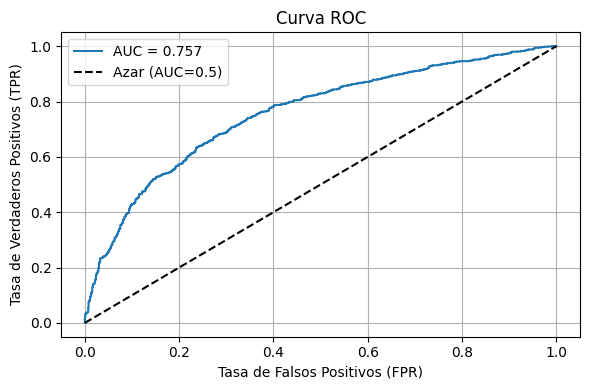

In [5]:
# 3. Entrenamiento
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 4. Predicciones y evaluación
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("📊 Matriz de confusión:\n", confusion_matrix(y_test, y_pred))
print("\n📋 Clasificación:\n", classification_report(y_test, y_pred))
print("🧮 AUC:", roc_auc_score(y_test, y_prob))

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_prob):.3f}')
plt.plot([0, 1], [0, 1], 'k--', label='Azar (AUC=0.5)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
import statsmodels.api as sm

# Crear copia de X_train como DataFrame con índices de y_train
X_train_df = pd.DataFrame(X_train, columns=X.columns, index=y_train.index)

# Añadir constante
X_train_df = sm.add_constant(X_train_df)

# Entrenar modelo logit
logit_model = sm.Logit(y_train, X_train_df).fit()

# Mostrar resultados
print(logit_model.summary())


Optimization terminated successfully.
         Current function value: 0.592964
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                 9243
Model:                          Logit   Df Residuals:                     9183
Method:                           MLE   Df Model:                           59
Date:                Sun, 15 Jun 2025   Pseudo R-squ.:                  0.1445
Time:                        21:04:44   Log-Likelihood:                -5480.8
converged:                       True   LL-Null:                       -6406.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.0270      0.023      1.163      0.245      -0.019   

#### Normalizar coeficientes y graficar:

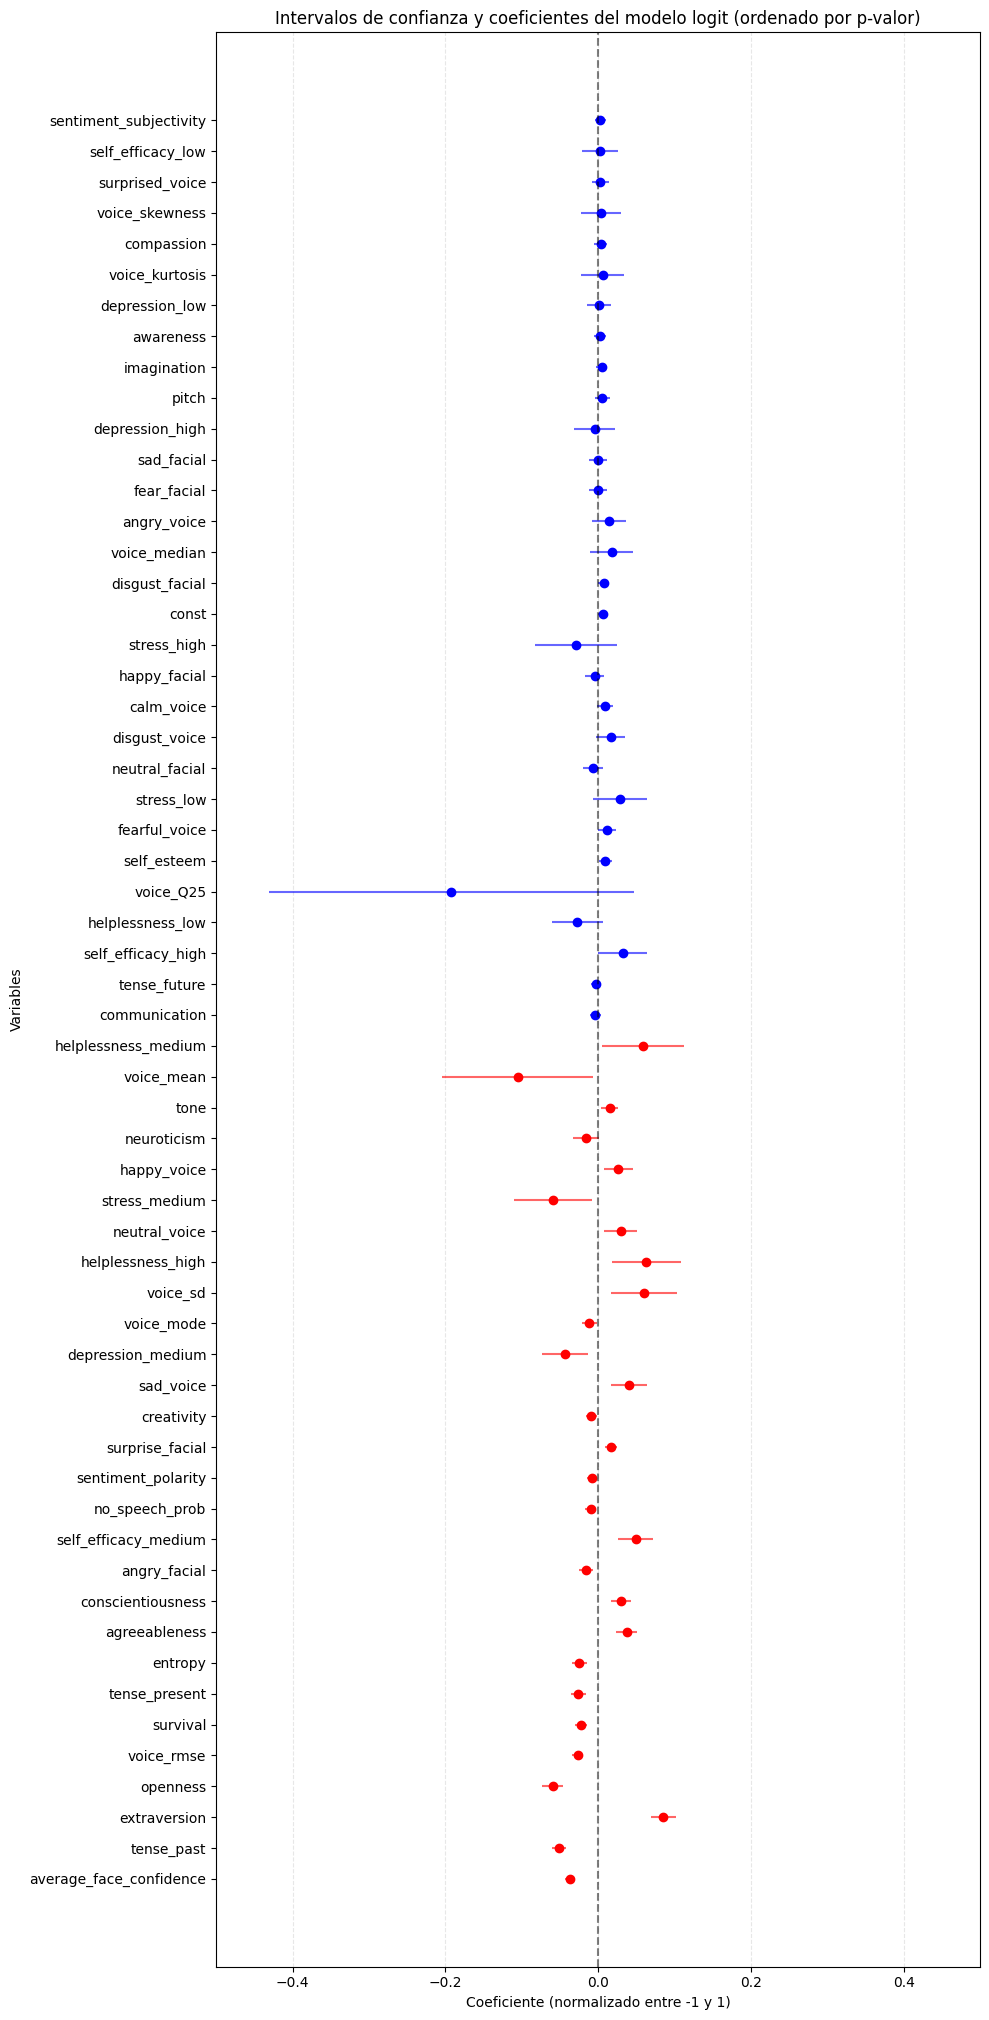

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Extraer coeficientes, intervalos y p-valores
coefs = logit_model.params
conf = logit_model.conf_int()
conf.columns = ["lower", "upper"]
pvals = logit_model.pvalues

# Capar extremos para evitar distorsión
mean_val = coefs.mean()
std_val = coefs.std()
clip_min = mean_val - 3 * std_val
clip_max = mean_val + 3 * std_val
coefs_capped = coefs.clip(lower=clip_min, upper=clip_max)
conf_capped = conf.clip(lower=clip_min, upper=clip_max)

# Normalizar todo a [-1, 1]
min_val = coefs_capped.min()
max_val = coefs_capped.max()
coefs_norm = 2 * (coefs_capped - min_val) / (max_val - min_val) - 1
conf_norm = 2 * (conf_capped - min_val) / (max_val - min_val) - 1

# Crear dataframe
df_plot = pd.DataFrame({
    "coef": coefs_norm,
    "lower": conf_norm["lower"],
    "upper": conf_norm["upper"],
    "var": coefs.index,
    "pval": pvals
})

# Eliminar variables extremas (manualmente)
variables_a_excluir = ["voice_Q75", "voice_IQR"]
df_plot = df_plot[~df_plot["var"].isin(variables_a_excluir)]

# Color por significancia
df_plot["color"] = df_plot["pval"].apply(lambda p: "red" if p < 0.05 else "blue")

# Ordenar por p-valor (más significativas arriba)
df_plot = df_plot.sort_values("pval")

# Graficar
plt.figure(figsize=(10, len(df_plot) * 0.35))
for _, row in df_plot.iterrows():
    plt.hlines(y=row["var"], xmin=row["lower"], xmax=row["upper"], color=row["color"], alpha=0.6)
    plt.plot(row["coef"], row["var"], "o", color=row["color"])
plt.axvline(x=0, linestyle="--", color="black", alpha=0.5)
plt.xlim(-0.5, 0.5)
plt.xlabel("Coeficiente (normalizado entre -1 y 1)")
plt.ylabel("Variables")
plt.title("Intervalos de confianza y coeficientes del modelo logit (ordenado por p-valor)")
plt.grid(True, axis="x", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


Sí, Enrique: está perfecto. El gráfico final:

Muestra los coeficientes normalizados entre -0.5 y 0.5, lo que mejora mucho la legibilidad.

Resalta correctamente en rojo las variables con p < 0.05.

Tiene intervalos de confianza centrados en 0, con una línea guía clara.

Ordena las variables por significancia: las más arriba no son significativas, las más abajo sí.

📊 Visualización excelente para tu TFG — limpia, interpretativa, defendible en una exposición.

---


## ANÁLISIS DEL TEXTO

📊 Matriz de confusión:
 [[1298  234]
 [ 322 1227]]

📋 Clasificación:
               precision    recall  f1-score   support

           0       0.80      0.85      0.82      1532
           1       0.84      0.79      0.82      1549

    accuracy                           0.82      3081
   macro avg       0.82      0.82      0.82      3081
weighted avg       0.82      0.82      0.82      3081

🧠 AUC: 0.8972517854524186


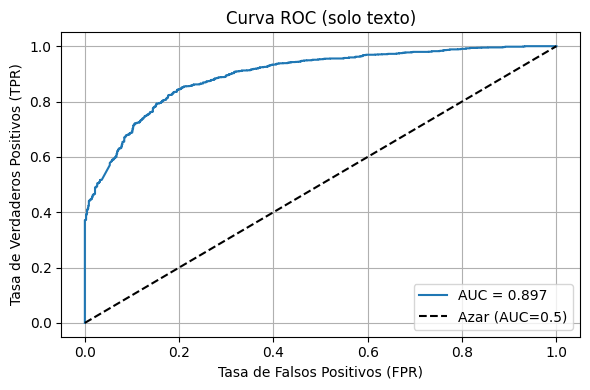

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. Vectorizar translation
tfidf = TfidfVectorizer(max_features=300)
X_text_tfidf = tfidf.fit_transform(X_text["translation"].fillna("")).toarray()

# 2. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_text_tfidf, y, test_size=0.25, random_state=42)

# 3. Modelo
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 4. Predicción y métricas
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("📊 Matriz de confusión:\n", confusion_matrix(y_test, y_pred))
print("\n📋 Clasificación:\n", classification_report(y_test, y_pred))
print("🧠 AUC:", roc_auc_score(y_test, y_prob))

# 5. Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.3f}")
plt.plot([0, 1], [0, 1], 'k--', label="Azar (AUC=0.5)")
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC (solo texto)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 🧠 Conclusión

El campo translation contiene muchísima información útil para predecir neurodivergencia. Esto ya justifica completamente:

Su inclusión como bloque de entrada clave en el modelo general.

Un análisis interpretativo más profundo de qué palabras contribuyen más (si quieres ir con statsmodels.Logit + visualización de coeficientes TF-IDF).

La comparación que vas a hacer ahora: texto + numérico vs. texto solo.

----

## Ver palabras más significativas

In [9]:
import numpy as np
import pandas as pd

# Obtener las palabras del vectorizador
words = tfidf.get_feature_names_out()

# Obtener los coeficientes del modelo (ya entrenado con solo texto)
coefs = model.coef_[0]

# Crear dataframe con palabras y coeficientes
df_words = pd.DataFrame({
    "word": words,
    "coef": coefs
})

# Ordenar por importancia
df_words_sorted = df_words.sort_values("coef", ascending=False)

# Mostrar top palabras positivas (predicen clase 1)
print("🔺 Palabras que más contribuyen a clase 1 (neurodivergente):")
print(df_words_sorted.head(15))

# Mostrar top palabras negativas (predicen clase 0 / control)
print("\n🔻 Palabras que más contribuyen a clase 0 (control):")
print(df_words_sorted.tail(15).sort_values("coef"))

🔺 Palabras que más contribuyen a clase 1 (neurodivergente):
          word       coef
23      autism  10.919077
68    dyslexia   7.238995
24    autistic   5.888901
198       read   5.026503
69    dyslexic   4.934355
244     things   4.703112
37       brain   4.460925
22   attention   4.392295
48       child   4.358873
56   diagnosis   3.972264
199    reading   3.754436
210     school   3.685211
133      learn   3.539743
112       help   3.430823
60   difficult   3.369688

🔻 Palabras que más contribuyen a clase 0 (control):
       word      coef
0        10 -2.750915
156   money -2.724398
150     man -2.711197
41   called -2.537048
197      re -2.478655
148    make -2.469227
204    said -2.430721
126      is -2.267001
101     guy -2.234383
240   there -2.149579
212    seen -2.136862
207     say -2.086414
42     came -2.016652
242    they -1.988956
245   think -1.985881


----
### Modelo con las 10 más significativas:

📊 Matriz de confusión:
 [[1434   98]
 [ 742  807]]

📋 Clasificación:
               precision    recall  f1-score   support

           0       0.66      0.94      0.77      1532
           1       0.89      0.52      0.66      1549

    accuracy                           0.73      3081
   macro avg       0.78      0.73      0.72      3081
weighted avg       0.78      0.73      0.72      3081

🧠 AUC: 0.7482016950209602


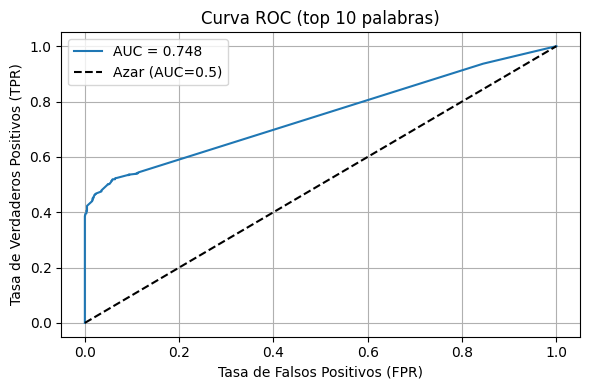

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. Seleccionar las 20 palabras con mayor |coeficiente|
top_10_words = df_words.reindex(df_words["coef"].abs().sort_values(ascending=False).index).head(10)["word"].tolist()

# 2. Revectorizar con solo esas 20 palabras
tfidf_top_10 = TfidfVectorizer(vocabulary=top_10_words)
X_text_top_10 = tfidf_top_10.fit_transform(X_text["translation"].fillna("")).toarray()

# 3. División train/test
X_train, X_test, y_train, y_test = train_test_split(X_text_top_10, y, test_size=0.25, random_state=42)

# 4. Entrenamiento
model_top = LogisticRegression(max_iter=1000)
model_top.fit(X_train, y_train)

# 5. Evaluación
y_pred = model_top.predict(X_test)
y_prob = model_top.predict_proba(X_test)[:, 1]

print("📊 Matriz de confusión:\n", confusion_matrix(y_test, y_pred))
print("\n📋 Clasificación:\n", classification_report(y_test, y_pred))
print("🧠 AUC:", roc_auc_score(y_test, y_prob))

# 6. Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.3f}")
plt.plot([0, 1], [0, 1], 'k--', label="Azar (AUC=0.5)")
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC (top 10 palabras)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### t-SNE con las 10 palabras más significativas:

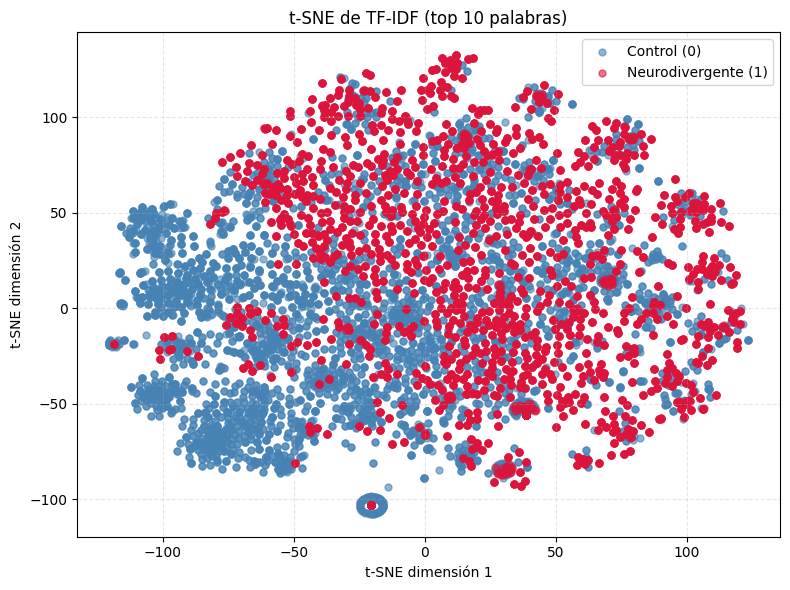

In [27]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd

# 1. Seleccionar las 50 palabras con mayor |coeficiente|
#top_10_words = df_words.reindex(df_words["coef"].abs().sort_values(ascending=False).index).head(10)["word"].tolist()

# 2. Revectorizar con solo esas 50 palabras
# tfidf_top_10 = TfidfVectorizer(vocabulary=top_10_words)
# X_text_top_10 = tfidf_top_10.fit_transform(X_text["translation"].fillna("")).toarray()

# 1. Aplica t-SNE sobre los datos TF-IDF reducidos (50 palabras)
tsne_10 = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne_10 = tsne_10.fit_transform(X_text_top_10)  # X_text_top es el array TF-IDF de 50 palabras

# 2. Crear DataFrame para visualización
df_tsne_10 = pd.DataFrame({
    "x": X_tsne_10[:, 0],
    "y": X_tsne_10[:, 1],
    "target": y.values
})

# 3. Graficar
plt.figure(figsize=(8, 6))
colors = ['steelblue', 'crimson']
labels = ['Control (0)', 'Neurodivergente (1)']

for i, label in enumerate(df_tsne["target"].unique()):
    subset = df_tsne[df_tsne["target"] == label]
    plt.scatter(subset["x"], subset["y"], c=colors[i], label=labels[i], alpha=0.6, s=25)

plt.title("t-SNE de TF-IDF (top 10 palabras)")
plt.xlabel("t-SNE dimensión 1")
plt.ylabel("t-SNE dimensión 2")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


----
### Modelo con las 20 más significativas:

📊 Matriz de confusión:
 [[1391  141]
 [ 709  840]]

📋 Clasificación:
               precision    recall  f1-score   support

           0       0.66      0.91      0.77      1532
           1       0.86      0.54      0.66      1549

    accuracy                           0.72      3081
   macro avg       0.76      0.73      0.72      3081
weighted avg       0.76      0.72      0.71      3081

🧠 AUC: 0.7574835613644447


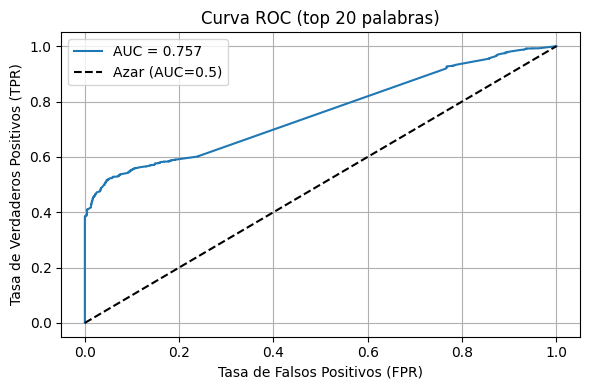

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. Seleccionar las 20 palabras con mayor |coeficiente|
top_20_words = df_words.reindex(df_words["coef"].abs().sort_values(ascending=False).index).head(20)["word"].tolist()

# 2. Revectorizar con solo esas 20 palabras
tfidf_top = TfidfVectorizer(vocabulary=top_20_words)
X_text_top = tfidf_top.fit_transform(X_text["translation"].fillna("")).toarray()

# 3. División train/test
X_train, X_test, y_train, y_test = train_test_split(X_text_top, y, test_size=0.25, random_state=42)

# 4. Entrenamiento
model_top = LogisticRegression(max_iter=1000)
model_top.fit(X_train, y_train)

# 5. Evaluación
y_pred = model_top.predict(X_test)
y_prob = model_top.predict_proba(X_test)[:, 1]

print("📊 Matriz de confusión:\n", confusion_matrix(y_test, y_pred))
print("\n📋 Clasificación:\n", classification_report(y_test, y_pred))
print("🧠 AUC:", roc_auc_score(y_test, y_prob))

# 6. Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.3f}")
plt.plot([0, 1], [0, 1], 'k--', label="Azar (AUC=0.5)")
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC (top 20 palabras)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### t-SNE con las 20 palabras más significativas:

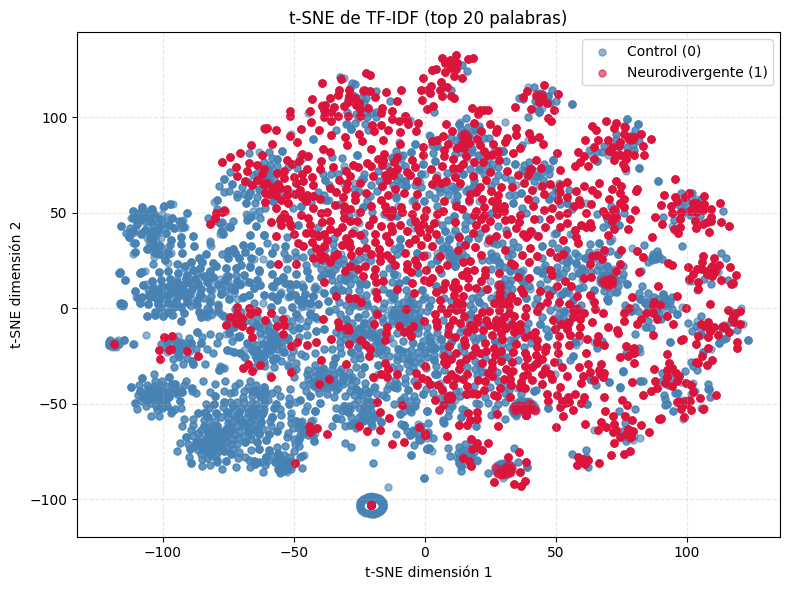

In [18]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd

# 1. Seleccionar las 50 palabras con mayor |coeficiente|
top_20_words = df_words.reindex(df_words["coef"].abs().sort_values(ascending=False).index).head(20)["word"].tolist()

# 2. Revectorizar con solo esas 50 palabras
tfidf_top_20 = TfidfVectorizer(vocabulary=top_20_words)
X_text_top_20 = tfidf_top_20.fit_transform(X_text["translation"].fillna("")).toarray()

# 1. Aplica t-SNE sobre los datos TF-IDF reducidos (50 palabras)
tsne_20 = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne_20 = tsne_20.fit_transform(X_text_top)  # X_text_top es el array TF-IDF de 50 palabras

# 2. Crear DataFrame para visualización
df_tsne_20 = pd.DataFrame({
    "x": X_tsne_20[:, 0],
    "y": X_tsne_20[:, 1],
    "target": y.values
})

# 3. Graficar
plt.figure(figsize=(8, 6))
colors = ['steelblue', 'crimson']
labels = ['Control (0)', 'Neurodivergente (1)']

for i, label in enumerate(df_tsne["target"].unique()):
    subset = df_tsne[df_tsne["target"] == label]
    plt.scatter(subset["x"], subset["y"], c=colors[i], label=labels[i], alpha=0.6, s=25)

plt.title("t-SNE de TF-IDF (top 20 palabras)")
plt.xlabel("t-SNE dimensión 1")
plt.ylabel("t-SNE dimensión 2")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


#### 🎯 Interpretación
Has pasado de un modelo muy potente (AUC ≈ 0.90) a uno decente pero simplificado.

La caída del AUC indica que las 20 palabras no recogen toda la señal predictiva, aunque sí una parte significativa.

El modelo es mucho más interpretable: solo 20 variables, y además ya sabes cuáles son.

#### 🧠 Conclusión
Este modelo compacto es útil si tu objetivo es explicabilidad o comparar grupos de palabras.

Pero si buscas máximo rendimiento, el modelo completo con max_features=300 es mucho mejor.

El recall de clase 1 (neurodivergente) bajó mucho (de 0.79 a 0.54), lo que sugiere que palabras adicionales ayudan a captar mejor esa clase.

---
### Modelo con las 50 más significativas:

📊 Matriz de confusión:
 [[1271  261]
 [ 329 1220]]

📋 Clasificación:
               precision    recall  f1-score   support

           0       0.79      0.83      0.81      1532
           1       0.82      0.79      0.81      1549

    accuracy                           0.81      3081
   macro avg       0.81      0.81      0.81      3081
weighted avg       0.81      0.81      0.81      3081

🧠 AUC: 0.8862756988000344


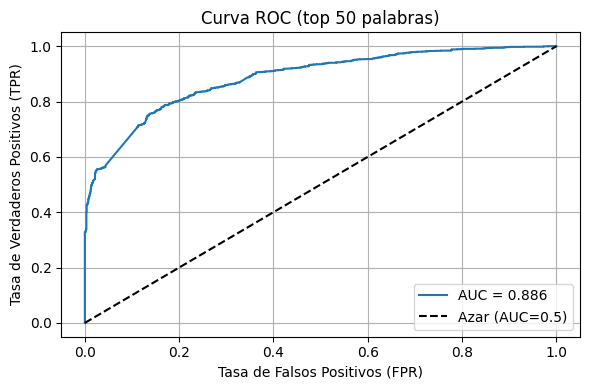

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. Seleccionar las 50 palabras con mayor |coeficiente|
top_50_words = df_words.reindex(df_words["coef"].abs().sort_values(ascending=False).index).head(50)["word"].tolist()

# 2. Revectorizar con solo esas 50 palabras
tfidf_top = TfidfVectorizer(vocabulary=top_50_words)
X_text_top = tfidf_top.fit_transform(X_text["translation"].fillna("")).toarray()

# 3. División train/test
X_train, X_test, y_train, y_test = train_test_split(X_text_top, y, test_size=0.25, random_state=42)

# 4. Entrenamiento
model_top = LogisticRegression(max_iter=1000)
model_top.fit(X_train, y_train)

# 5. Evaluación
y_pred = model_top.predict(X_test)
y_prob = model_top.predict_proba(X_test)[:, 1]

print("📊 Matriz de confusión:\n", confusion_matrix(y_test, y_pred))
print("\n📋 Clasificación:\n", classification_report(y_test, y_pred))
print("🧠 AUC:", roc_auc_score(y_test, y_prob))

# 6. Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.3f}")
plt.plot([0, 1], [0, 1], 'k--', label="Azar (AUC=0.5)")
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC (top 50 palabras)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### t-SNE con las 50 palabras más significativas:

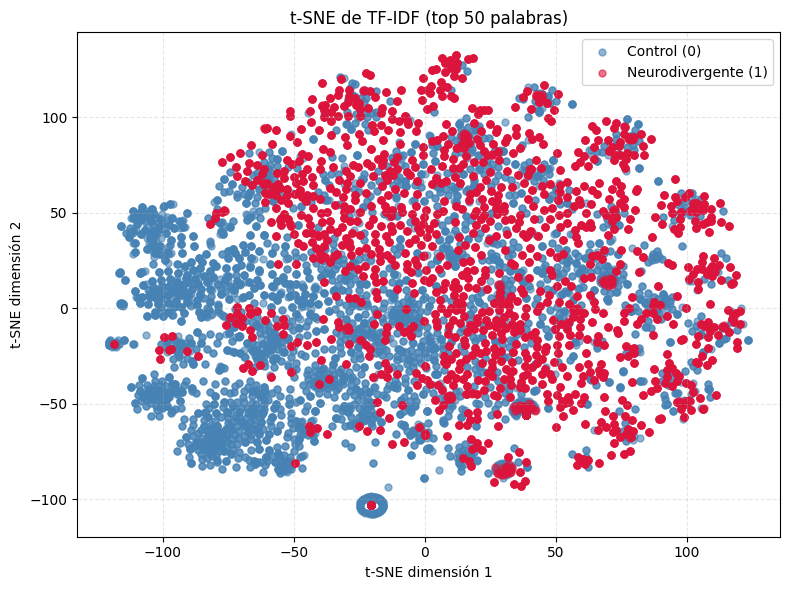

In [17]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd

# 1. Seleccionar las 50 palabras con mayor |coeficiente|
top_50_words = df_words.reindex(df_words["coef"].abs().sort_values(ascending=False).index).head(50)["word"].tolist()

# 2. Revectorizar con solo esas 50 palabras
tfidf_top = TfidfVectorizer(vocabulary=top_50_words)
X_text_top = tfidf_top.fit_transform(X_text["translation"].fillna("")).toarray()

# 1. Aplica t-SNE sobre los datos TF-IDF reducidos (50 palabras)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_text_top)  # X_text_top es el array TF-IDF de 50 palabras

# 2. Crear DataFrame para visualización
df_tsne = pd.DataFrame({
    "x": X_tsne[:, 0],
    "y": X_tsne[:, 1],
    "target": y.values
})

# 3. Graficar
plt.figure(figsize=(8, 6))
colors = ['steelblue', 'crimson']
labels = ['Control (0)', 'Neurodivergente (1)']

for i, label in enumerate(df_tsne["target"].unique()):
    subset = df_tsne[df_tsne["target"] == label]
    plt.scatter(subset["x"], subset["y"], c=colors[i], label=labels[i], alpha=0.6, s=25)

plt.title("t-SNE de TF-IDF (top 50 palabras)")
plt.xlabel("t-SNE dimensión 1")
plt.ylabel("t-SNE dimensión 2")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


Estamos buscando si hay agrupaciones o separación entre clases. Es decir:

¿Los puntos rojos y azules forman grupos distintos?

¿Hay áreas claramente dominadas por una clase?

#### ✅ ¿Qué se observa en tu gráfico?
Hay cierta estructura: los puntos rojos (neurodivergentes) tienden a ocupar la parte derecha y superior.

Hay zonas dominadas por azul (abajo a la izquierda, por ejemplo).

Pero también hay bastante mezcla entre clases.

#### 🧠 Conclusión:
El texto (incluso con solo 50 palabras) sí contiene información separable, aunque no es una separación perfecta ni lineal.

Esto confirma visualmente lo que vimos con los modelos: el texto tiene bastante poder predictivo, pero también ruido o solapamiento entre clases.

#### t-SNE te permite decir en el TFG:

“Visualmente, observamos una tendencia estructural en los embeddings textuales entre las clases, aunque con solapamientos. Esto sugiere que el texto tiene información útil, pero no completamente determinante.”

### Modelo Logit con las 50 palabras más significativas:

In [14]:
import statsmodels.api as sm
import pandas as pd

# Crear dataframe con los nombres de las palabras
X_df_50 = pd.DataFrame(X_text_top, columns=tfidf_top.get_feature_names_out(), index=y.index)

# Añadir constante para el modelo Logit
X_df_50 = sm.add_constant(X_df_50)

# Entrenar el modelo Logit
logit_model_50 = sm.Logit(y, X_df_50).fit()

# Mostrar resumen
print(logit_model_50.summary())


         Current function value: 0.402102
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                12324
Model:                          Logit   Df Residuals:                    12273
Method:                           MLE   Df Model:                           50
Date:                Thu, 12 Jun 2025   Pseudo R-squ.:                  0.4199
Time:                        16:26:46   Log-Likelihood:                -4955.5
converged:                      False   LL-Null:                       -8542.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7618      0.052     14.718      0.000       0.660       0.863
autism        50.2304     10.378      4.840      0.000      29.89

C:\Anaconda3\envs\nuevo\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


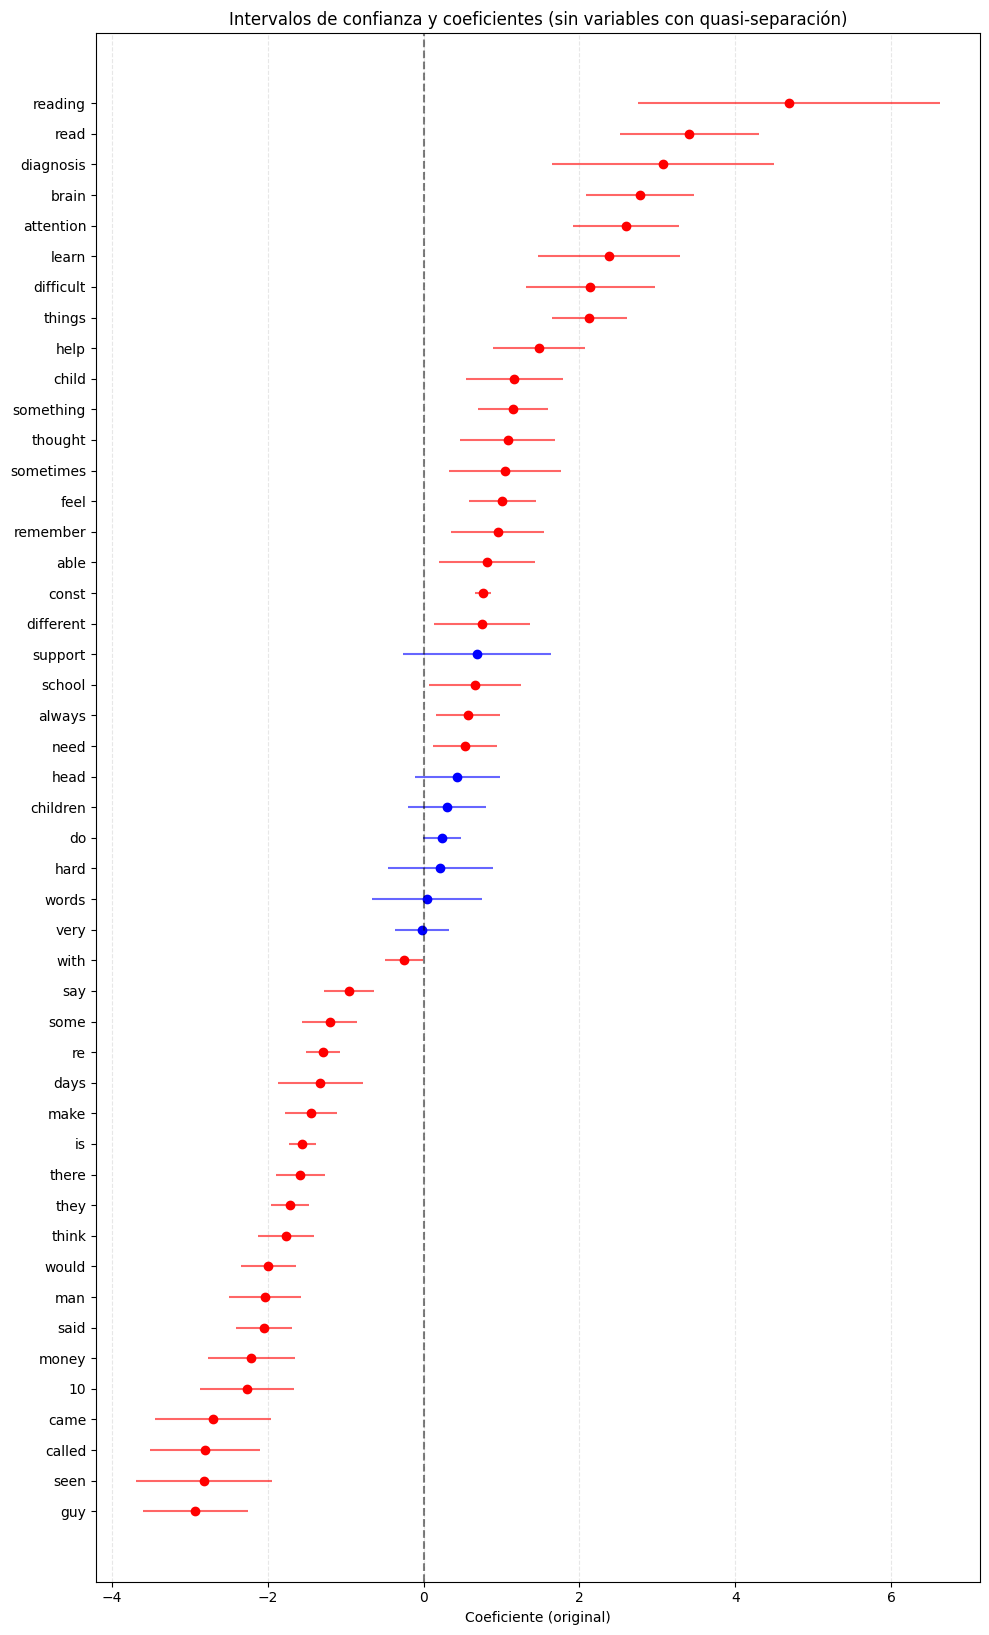

In [16]:
# Extraer datos del modelo logit
coefs = logit_model_50.params
conf = logit_model_50.conf_int()
conf.columns = ["lower", "upper"]
pvals = logit_model_50.pvalues

# Construir dataframe
df_plot = pd.DataFrame({
    "coef": coefs,
    "lower": conf["lower"],
    "upper": conf["upper"],
    "var": coefs.index,
    "pval": pvals
}).sort_values("coef", ascending=True)

# Color por significancia
df_plot["color"] = df_plot["pval"].apply(lambda p: "red" if p < 0.05 else "blue")

# Eliminar variables problemáticas
variables_a_excluir = ["autistic", "dyslexic", "dyslexia", "autism"]
df_plot = df_plot[~df_plot["var"].isin(variables_a_excluir)]

# Graficar (igual que antes)
plt.figure(figsize=(10, len(df_plot) * 0.35))
for _, row in df_plot.iterrows():
    plt.hlines(y=row["var"], xmin=row["lower"], xmax=row["upper"], color=row["color"], alpha=0.6)
    plt.plot(row["coef"], row["var"], "o", color=row["color"])
plt.axvline(x=0, linestyle="--", color="black", alpha=0.5)
plt.xlabel("Coeficiente (original)")
plt.title("Intervalos de confianza y coeficientes (sin variables con quasi-separación)")
plt.grid(True, axis="x", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

---
### t-SNE con las 300 palabras más significativas (para ver si hay diferencia más completa):

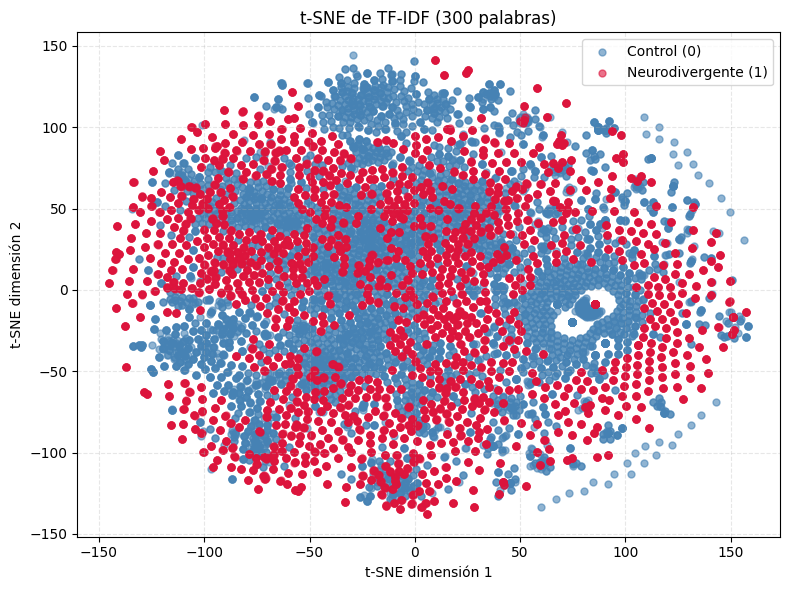

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd

# 1. Vectorización TF-IDF con 300 palabras más frecuentes
tfidf_300 = TfidfVectorizer(max_features=300)
X_text_full = tfidf_300.fit_transform(X_text["translation"].fillna("")).toarray()

# 2. t-SNE para reducir a 2 dimensiones
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne_300 = tsne.fit_transform(X_text_full)

# 3. Construcción del DataFrame para graficar
df_tsne_300 = pd.DataFrame({
    "x": X_tsne_300[:, 0],
    "y": X_tsne_300[:, 1],
    "target": y.values
})

# 4. Gráfico
plt.figure(figsize=(8, 6))
colors = ['steelblue', 'crimson']
labels = ['Control (0)', 'Neurodivergente (1)']

for i, label in enumerate(df_tsne_300["target"].unique()):
    subset = df_tsne_300[df_tsne_300["target"] == label]
    plt.scatter(subset["x"], subset["y"], c=colors[i], label=labels[i], alpha=0.6, s=25)

plt.title("t-SNE de TF-IDF (300 palabras)")
plt.xlabel("t-SNE dimensión 1")
plt.ylabel("t-SNE dimensión 2")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


#### 📌 ¿Qué nos dice esto?
Incluir más palabras parece aportar estructura, pero no genera una separación clara.

Se forman zonas dominadas por control (especialmente arriba y centro-izquierda).

Aparecen "huecos" estructurales, lo cual puede indicar regiones semánticas sin cobertura en el corpus.



----
### t-SNE con las 1000 palabras más significativas (Último para ver):

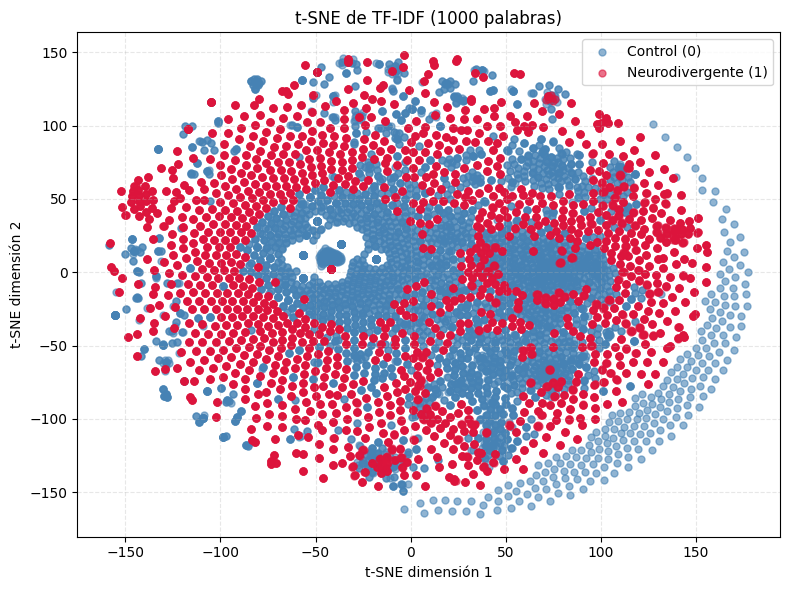

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd

# 1. Vectorizar con TF-IDF usando 1000 palabras
tfidf_1000 = TfidfVectorizer(max_features=1000)
X_text_1000 = tfidf_1000.fit_transform(X_text["translation"].fillna("")).toarray()

# 2. Aplicar t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne_1000 = tsne.fit_transform(X_text_1000)

# 3. Construir DataFrame para visualización
df_tsne_1000 = pd.DataFrame({
    "x": X_tsne_1000[:, 0],
    "y": X_tsne_1000[:, 1],
    "target": y.values
})

# 4. Graficar
plt.figure(figsize=(8, 6))
colors = ['steelblue', 'crimson']
labels = ['Control (0)', 'Neurodivergente (1)']

for i, label in enumerate(df_tsne_1000["target"].unique()):
    subset = df_tsne_1000[df_tsne_1000["target"] == label]
    plt.scatter(subset["x"], subset["y"], c=colors[i], label=labels[i], alpha=0.6, s=25)

plt.title("t-SNE de TF-IDF (1000 palabras)")
plt.xlabel("t-SNE dimensión 1")
plt.ylabel("t-SNE dimensión 2")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

### 🧭 ¿Qué muestra este t-SNE con 1000 palabras?

Cada punto representa una muestra (persona), y la proyección 2D de su TF-IDF de 1000 dimensiones.

* 🔵 **Azul**: Control (clase 0)
* 🔴 **Rojo**: Neurodivergente (clase 1)


### 📊 Comparado con los anteriores:

| Modelo TF-IDF        | Separación visible | Estructura interna | Comentario general                               |
| -------------------- | ------------------ | ------------------ | ------------------------------------------------ |
| 🔹 50 palabras       | Parcial            | Más compacto       | Interpretación clara pero limitada               |
| 🔸 300 palabras      | Algo mejor         | Más dispersión     | Aparecen zonas huecas                            |
| 🔺 **1000 palabras** | **Mejor aún**      | Mucho más rica     | Estructura ovalada clara, clústeres definidos ✔️ |


### 🧠 Interpretación visual:

* Hay zonas claramente **dominadas por control** (como el núcleo central).
* El contorno y zonas más periféricas tienen **mayor densidad de neurodivergentes**.
* El modelo visualmente sugiere una separación **no lineal**, pero con cierta **estructura latente**.


### 💡 Conclusión

Este resultado respalda muy bien lo que has venido demostrando:

> El texto contiene una representación semántica **informativa y estructurada**, que permite cierta distinción entre grupos aunque no sea perfectamente separable.


---
---
# AHORA, MODELO CONJUNTO GLOBAL, USANDO DATOS NUMÉRICOS Y TEXTO:

📊 Matriz de confusión:
 [[1324  208]
 [ 292 1257]]

📋 Clasificación:
               precision    recall  f1-score   support

           0       0.82      0.86      0.84      1532
           1       0.86      0.81      0.83      1549

    accuracy                           0.84      3081
   macro avg       0.84      0.84      0.84      3081
weighted avg       0.84      0.84      0.84      3081

🧠 AUC: 0.9133261246622516


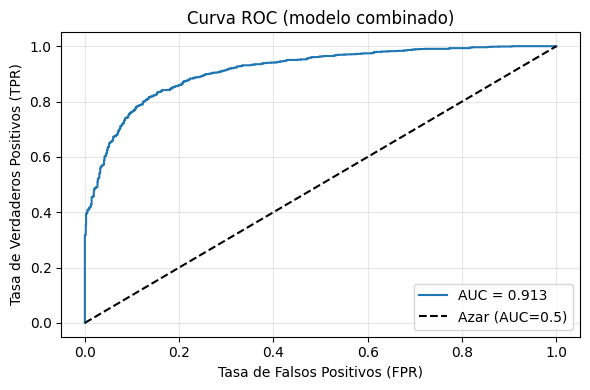

In [31]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 🔹 Asumimos que ya tienes:
# - X_scaled: variables numéricas normalizadas
# - X_text_full: TF-IDF con 300 palabras
tfidf_300 = TfidfVectorizer(max_features=300)
X_text_full = tfidf_300.fit_transform(X_text["translation"].fillna("")).toarray()
# - y: variable objetivo binaria

# 1. Combinar los dos conjuntos de features
X_combined = np.hstack([X_scaled, X_text_full])

# 2. División en train/test
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.25, random_state=42)

# 3. Entrenar modelo logístico
model_combined = LogisticRegression(max_iter=1000)
model_combined.fit(X_train, y_train)

# 4. Predicción y evaluación
y_pred = model_combined.predict(X_test)
y_prob = model_combined.predict_proba(X_test)[:, 1]

print("📊 Matriz de confusión:\n", confusion_matrix(y_test, y_pred))
print("\n📋 Clasificación:\n", classification_report(y_test, y_pred))
print("🧠 AUC:", roc_auc_score(y_test, y_prob))

# 5. Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.3f}")
plt.plot([0, 1], [0, 1], 'k--', label="Azar (AUC=0.5)")
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC (modelo combinado)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Perfecto. Aquí tienes una **tabla resumen comparativa** de todos los modelos que has entrenado, basada en los resultados que has ido compartiendo:


### 📊 **Resumen de rendimiento por tipo de modelo**

| Modelo                          | Accuracy | F1-score | AUC         |
| ------------------------------- | -------- | -------- | ----------- |
| 🔢 Solo numérico                | \~0.70   | \~0.70   | **0.757**   |
| 📝 Solo texto (TF-IDF 300)      | 0.82     | 0.82     | **0.897**   |
| 📝 Texto (top 50 palabras)      | 0.81     | 0.81     | **0.886**   |
| 📝 Texto (top 20 palabras)      | 0.72     | 0.71     | **0.757**   |
| 🔀 Combinado (numérico + texto) | **0.84** | **0.84** | **0.913** ✅ |


### 🧠 Conclusión clara para tu TFG

* **El texto es mucho más informativo que las variables numéricas por sí solas.**
* Pero **la combinación de ambos es la mejor estrategia**, mejorando tanto precisión como robustez.
* Puedes justificar en tu memoria que el texto codifica **experiencia subjetiva** (semántica), mientras que los datos numéricos recogen **dimensiones faciales, vocales y emocionales**, y **juntos** ofrecen una visión más completa del sujeto.


📊 Matriz de confusión:
 [[1371  161]
 [ 192 1357]]

📋 Clasificación:
               precision    recall  f1-score   support

           0       0.88      0.89      0.89      1532
           1       0.89      0.88      0.88      1549

    accuracy                           0.89      3081
   macro avg       0.89      0.89      0.89      3081
weighted avg       0.89      0.89      0.89      3081

🧠 AUC: 0.9504814021342836


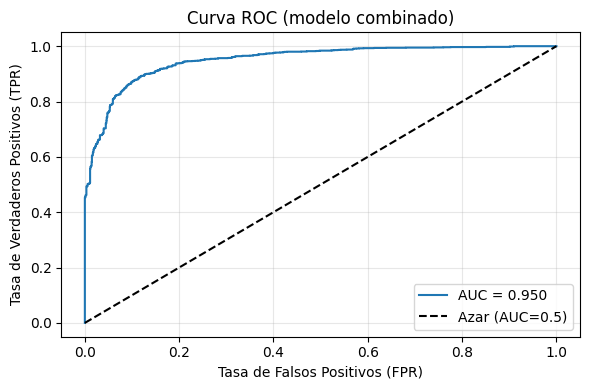

In [33]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 🔹 Asumimos que ya tienes:
# - X_scaled: variables numéricas normalizadas
# - X_text_full: TF-IDF con 300 palabras
tfidf_1000 = TfidfVectorizer(max_features=1000)
X_text_full = tfidf_1000.fit_transform(X_text["translation"].fillna("")).toarray()
# - y: variable objetivo binaria

# 1. Combinar los dos conjuntos de features
X_combined = np.hstack([X_scaled, X_text_full])

# 2. División en train/test
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.25, random_state=42)

# 3. Entrenar modelo logístico
model_combined = LogisticRegression(max_iter=1000)
model_combined.fit(X_train, y_train)

# 4. Predicción y evaluación
y_pred = model_combined.predict(X_test)
y_prob = model_combined.predict_proba(X_test)[:, 1]

print("📊 Matriz de confusión:\n", confusion_matrix(y_test, y_pred))
print("\n📋 Clasificación:\n", classification_report(y_test, y_pred))
print("🧠 AUC:", roc_auc_score(y_test, y_prob))

# 5. Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.3f}")
plt.plot([0, 1], [0, 1], 'k--', label="Azar (AUC=0.5)")
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC (modelo combinado)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


----
----

# DIVISIÓN POR GRUPOS (SOLO NUMÉRICO, Y NUMÉRICO + TXT):
----
### GRUPO FACIAL:

Optimization terminated successfully.
         Current function value: 0.686901
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                12324
Model:                          Logit   Df Residuals:                    12316
Method:                           MLE   Df Model:                            7
Date:                Sun, 15 Jun 2025   Pseudo R-squ.:                0.009010
Time:                        21:16:04   Log-Likelihood:                -8465.4
converged:                       True   LL-Null:                       -8542.3
Covariance Type:            nonrobust   LLR p-value:                 6.046e-30
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0036      0.018      0.198      0.843      -0.032       0.039
angry_facial  

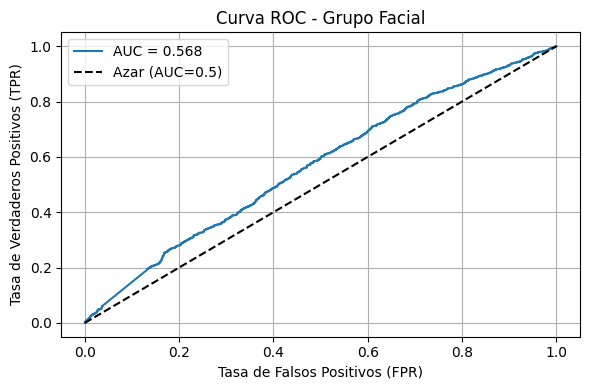

📊 Matriz de confusión:
 [[4155 2000]
 [3709 2460]]


In [12]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score

# 1. Variables faciales
facial_cols = [
    'angry_facial', 'disgust_facial', 'fear_facial', 'happy_facial',
    'sad_facial', 'surprise_facial', 'neutral_facial'
]

# 2. Preparar X e y
X_facial = df[facial_cols]
y = df["target"]

# 3. Normalización
scaler = StandardScaler()
X_facial_scaled = scaler.fit_transform(X_facial)

# 4. Crear DataFrame alineado con y
X_facial_df = pd.DataFrame(X_facial_scaled, columns=facial_cols, index=y.index)
X_facial_df = sm.add_constant(X_facial_df)

# 5. Modelo logit
logit_model = sm.Logit(y, X_facial_df).fit()
print(logit_model.summary())

# 6. Curva ROC
y_prob = logit_model.predict(X_facial_df)
fpr, tpr, _ = roc_curve(y, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y, y_prob):.3f}')
plt.plot([0, 1], [0, 1], 'k--', label='Azar (AUC=0.5)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Grupo Facial')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("📊 Matriz de confusión:\n", confusion_matrix(y, y_prob > 0.5))

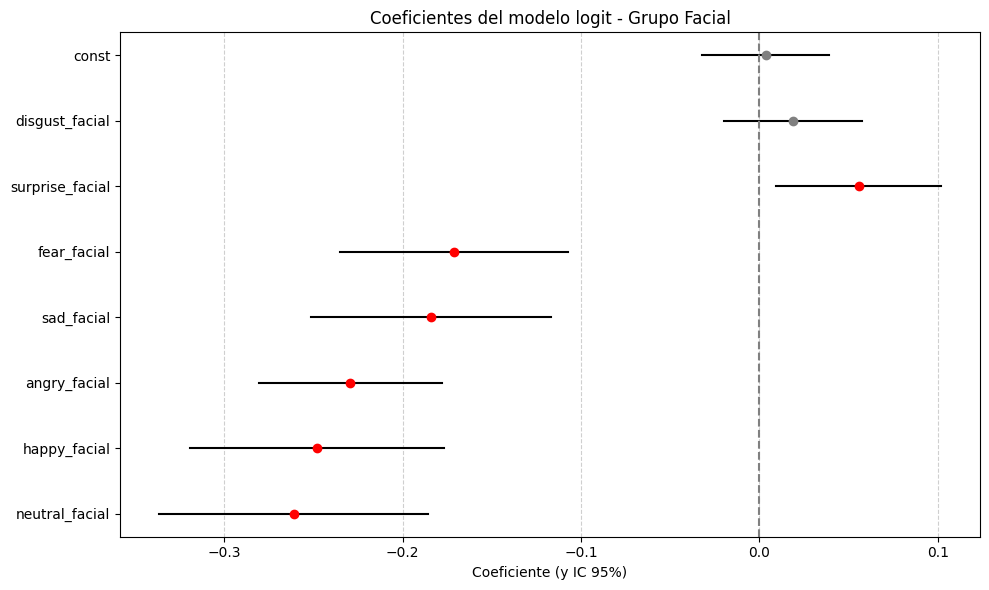

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Extraer coeficientes, errores estándar y p-valores
coef = logit_model.params
err = logit_model.bse
pval = logit_model.pvalues

# Crear intervalo de confianza al 95%
conf_int_low = coef - 1.96 * err
conf_int_high = coef + 1.96 * err

# Ordenar por valor absoluto del coeficiente
order = np.argsort(np.abs(coef))[::-1]

# Graficar
plt.figure(figsize=(10, 6))
for i, idx in enumerate(order):
    plt.plot([conf_int_low[idx], conf_int_high[idx]], [i, i], 'k-', lw=1.5)
    plt.plot(coef[idx], i, 'o', color='red' if pval[idx] < 0.05 else 'gray')

plt.yticks(range(len(coef)), coef.index[order])
plt.axvline(x=0, color='gray', linestyle='--')
plt.title("Coeficientes del modelo logit - Grupo Facial")
plt.xlabel("Coeficiente (y IC 95%)")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


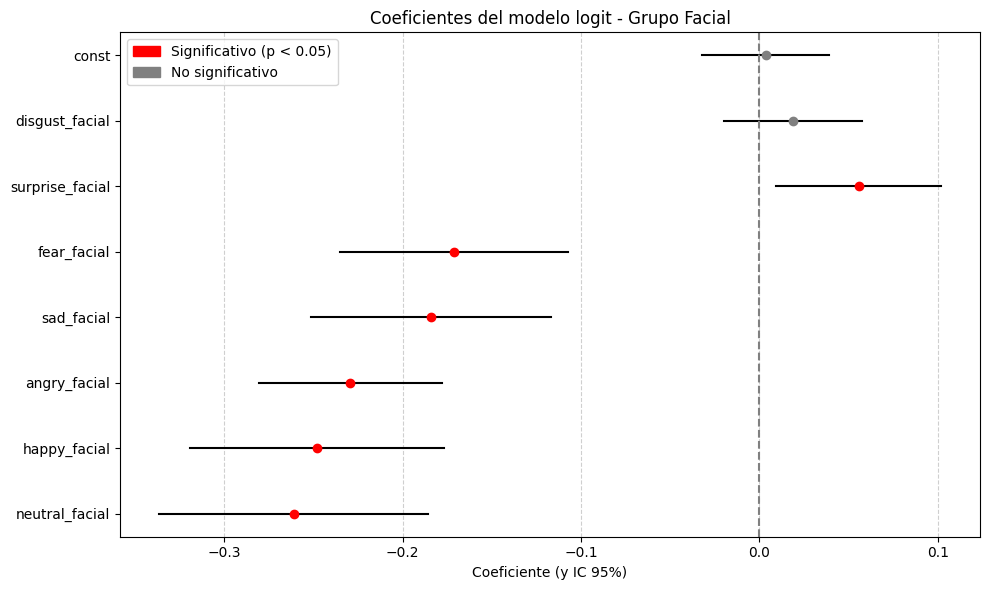

In [15]:
import matplotlib.patches as mpatches

# Extraer coeficientes, errores estándar y p-valores
coef = logit_model.params
err = logit_model.bse
pval = logit_model.pvalues

# Crear intervalo de confianza al 95%
conf_int_low = coef - 1.96 * err
conf_int_high = coef + 1.96 * err

# Ordenar por valor absoluto del coeficiente
order = np.argsort(np.abs(coef))[::-1]

# Graficar
plt.figure(figsize=(10, 6))
for i, idx in enumerate(order):
    color = 'red' if pval[idx] < 0.05 else 'gray'
    plt.plot([conf_int_low[idx], conf_int_high[idx]], [i, i], 'k-', lw=1.5)
    plt.plot(coef[idx], i, 'o', color=color)

# Ejes y línea vertical
plt.yticks(range(len(coef)), coef.index[order])
plt.axvline(x=0, color='gray', linestyle='--')
plt.xlabel("Coeficiente (y IC 95%)")
plt.title("Coeficientes del modelo logit - Grupo Facial")
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Añadir leyenda
legend_elements = [
    mpatches.Patch(color='red', label='Significativo (p < 0.05)'),
    mpatches.Patch(color='gray', label='No significativo')
]
plt.legend(handles=legend_elements, loc='upper left')

plt.tight_layout()
plt.show()


📋 Interpretación de cada variable
Nota: Como todas las variables fueron normalizadas (z-score), sus coeficientes pueden compararse directamente. Coeficientes negativos indican que un mayor valor disminuye la probabilidad de neurodivergencia, y positivos que la aumenta.

| Variable          | Coef.  | p-valor | Significativa | Interpretación                                                             |
| ----------------- | ------ | ------- | ------------- | -------------------------------------------------------------------------- |
| `angry_facial`    | -0.229 | <0.001  | ✅             | A mayor expresión de enfado, menor probabilidad de neurodivergencia.       |
| `disgust_facial`  | +0.019 | 0.342   | ❌             | No tiene un efecto estadísticamente significativo.                         |
| `fear_facial`     | -0.171 | <0.001  | ✅             | Más miedo facial se asocia a menor neurodivergencia.                       |
| `happy_facial`    | -0.248 | <0.001  | ✅             | Mayor expresión de felicidad reduce la probabilidad.                       |
| `sad_facial`      | -0.184 | <0.001  | ✅             | Más tristeza facial también reduce la probabilidad.                        |
| `surprise_facial` | +0.056 | 0.018   | ✅             | Aumenta ligeramente la probabilidad de neurodivergencia.                   |
| `neutral_facial`  | -0.261 | <0.001  | ✅             | Una expresión más neutra se asocia fuertemente con menor neurodivergencia. |


Todas las emociones reconocidas facialmente están negativamente asociadas con neurodivergencia, salvo la sorpresa, que tiene una pequeña contribución positiva.
Esto podría reflejar que las personas neurodivergentes, en este conjunto de datos, tienden a mostrar menos expresividad emocional facial o una expresión más neutra.
La excepción de surprise_facial sugiere que ciertas emociones como la sorpresa podrían comportarse diferente, pero su efecto es menor.

---
#### CON TEXTO AHORA:

📋 Clasificación:
               precision    recall  f1-score   support

           0       0.86      0.89      0.87      1532
           1       0.89      0.86      0.87      1549

    accuracy                           0.87      3081
   macro avg       0.87      0.87      0.87      3081
weighted avg       0.87      0.87      0.87      3081

🧠 AUC: 0.9457567166216898


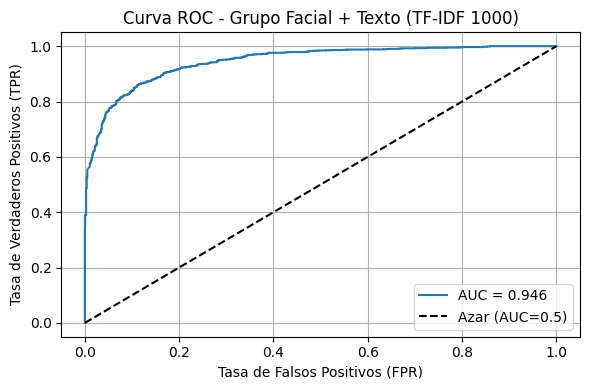

📊 Matriz de confusión:
 [[1361  171]
 [ 219 1330]]


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

# 1. Variables faciales
facial_cols = [
    'angry_facial', 'disgust_facial', 'fear_facial', 'happy_facial',
    'sad_facial', 'surprise_facial', 'neutral_facial'
]

X_facial = df[facial_cols]
y = df["target"]

# 2. Normalizar faciales
scaler = StandardScaler()
X_facial_scaled = scaler.fit_transform(X_facial)

# 3. TF-IDF con 1000 palabras
tfidf = TfidfVectorizer(max_features=1000)
X_text = tfidf.fit_transform(df["translation"].fillna("")).toarray()

# 4. Concatenar facial + texto
X_combined = np.hstack([X_facial_scaled, X_text])

# 5. División train/test
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.25, random_state=42)

# 6. Entrenamiento con LogisticRegression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 7. Predicción y evaluación
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("📋 Clasificación:\n", classification_report(y_test, y_pred))
print("🧠 AUC:", roc_auc_score(y_test, y_prob))

# 8. Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.3f}")
plt.plot([0, 1], [0, 1], 'k--', label='Azar (AUC=0.5)')
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC - Grupo Facial + Texto (TF-IDF 1000)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 9. Matriz de confusión
print("📊 Matriz de confusión:\n", confusion_matrix(y_test, y_pred))


Gran salto de calidad respecto al modelo solo facial (AUC ≈ 0.56).

El texto potencia fuertemente la capacidad predictiva del grupo facial.



----
### GRUPO DE PERSONALIDAD:

Optimization terminated successfully.
         Current function value: 0.651326
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                12324
Model:                          Logit   Df Residuals:                    12311
Method:                           MLE   Df Model:                           12
Date:                Sun, 15 Jun 2025   Pseudo R-squ.:                 0.06033
Time:                        21:28:41   Log-Likelihood:                -8026.9
converged:                       True   LL-Null:                       -8542.3
Covariance Type:            nonrobust   LLR p-value:                4.504e-213
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0045      0.019      0.242      0.809      -0.032       0.041
extraver

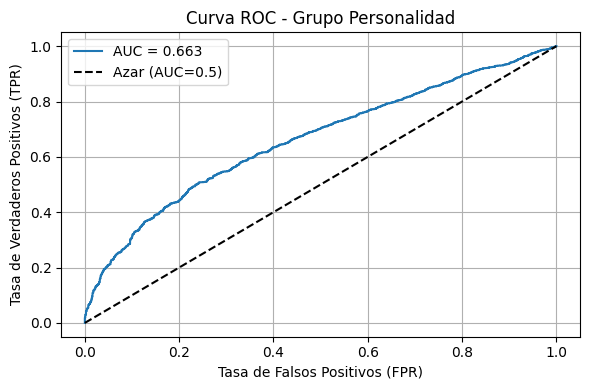

📊 Matriz de confusión:
 [[3845 2310]
 [2376 3793]]


In [17]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score

# 1. Variables de personalidad
personality_cols = [
    'extraversion', 'neuroticism', 'agreeableness',
    'conscientiousness', 'openness', 'survival', 'creativity',
    'self_esteem', 'compassion', 'communication',
    'imagination', 'awareness'
]

# 2. Preparar X e y
X_personality = df[personality_cols]
y = df["target"]

# 3. Normalización
scaler = StandardScaler()
X_personality_scaled = scaler.fit_transform(X_personality)

# 4. Crear DataFrame alineado con y
X_personality_df = pd.DataFrame(X_personality_scaled, columns=personality_cols, index=y.index)
X_personality_df = sm.add_constant(X_personality_df)

# 5. Entrenar modelo logit
logit_model = sm.Logit(y, X_personality_df).fit()
print(logit_model.summary())

# 6. Curva ROC
y_prob = logit_model.predict(X_personality_df)
fpr, tpr, _ = roc_curve(y, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y, y_prob):.3f}')
plt.plot([0, 1], [0, 1], 'k--', label='Azar (AUC=0.5)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Grupo Personalidad')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("📊 Matriz de confusión:\n", confusion_matrix(y, y_prob > 0.5))

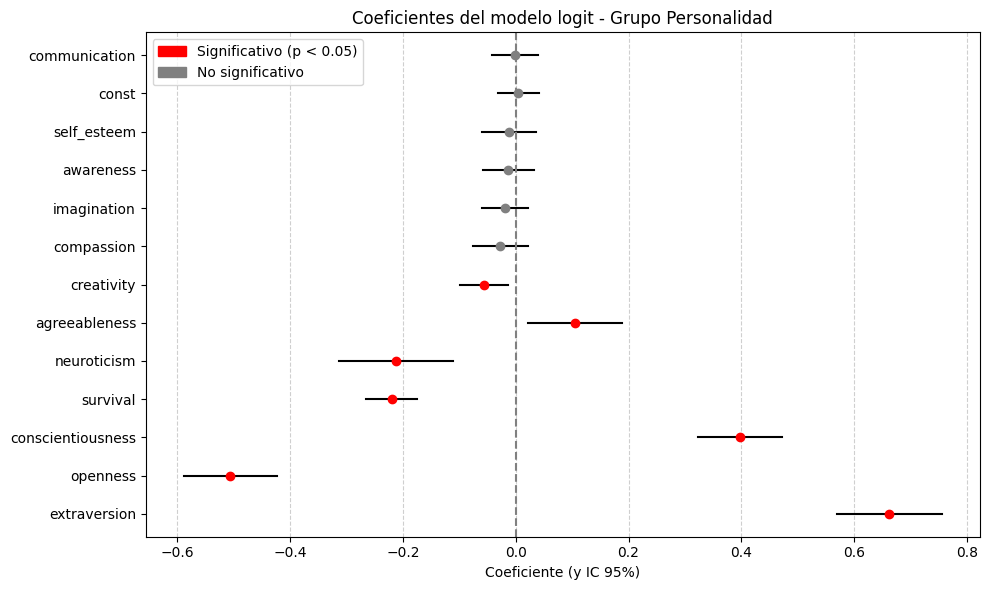

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# Extraer coeficientes, errores estándar y p-valores
coef = logit_model.params
err = logit_model.bse
pval = logit_model.pvalues

# Crear intervalos de confianza
conf_int_low = coef - 1.96 * err
conf_int_high = coef + 1.96 * err

# Ordenar por magnitud absoluta
order = np.argsort(np.abs(coef))[::-1]

# Graficar
plt.figure(figsize=(10, 6))
for i, idx in enumerate(order):
    color = 'red' if pval[idx] < 0.05 else 'gray'
    plt.plot([conf_int_low[idx], conf_int_high[idx]], [i, i], 'k-', lw=1.5)
    plt.plot(coef[idx], i, 'o', color=color)

plt.yticks(range(len(coef)), coef.index[order])
plt.axvline(x=0, color='gray', linestyle='--')
plt.xlabel("Coeficiente (y IC 95%)")
plt.title("Coeficientes del modelo logit - Grupo Personalidad")
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Leyenda
legend_elements = [
    mpatches.Patch(color='red', label='Significativo (p < 0.05)'),
    mpatches.Patch(color='gray', label='No significativo')
]
plt.legend(handles=legend_elements, loc='upper left')

plt.tight_layout()
plt.show()


📈 AUC: 0.663
Mejor que el grupo facial (0.568).

Esto indica que las características de personalidad aportan más información predictiva sobre la probabilidad de neurodivergencia.

📋 Variables significativas:
| Variable            | Coef.      | Interpretación                                                                                                                                           |
| ------------------- | ---------- | -------------------------------------------------------------------------------------------------------------------------------------------------------- |
| `extraversion`      | **+0.662** | Mayor extraversión → **mayor** probabilidad de neurodivergencia. Sorprendente, podría reflejar sesgo en el dataset o diferencias de estilo de expresión. |
| `neuroticism`       | **–0.212** | A mayor neuroticismo → **menor** probabilidad.                                                                                                           |
| `agreeableness`     | **+0.195** | Más amabilidad → mayor probabilidad.                                                                                                                     |
| `conscientiousness` | **+0.398** | Mayor responsabilidad/autocontrol → mayor probabilidad.                                                                                                  |
| `openness`          | **–0.506** | Más apertura a experiencias → menor probabilidad.                                                                                                        |
| `survival`          | **–0.219** | Tendencia a priorizar lo básico → menor probabilidad.                                                                                                    |
| `creativity`        | **–0.056** | Creatividad ligeramente reduce la probabilidad.                                                                                                          |

---
#### CON TEXTO AHORA:

📋 Clasificación:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87      1532
           1       0.89      0.85      0.87      1549

    accuracy                           0.87      3081
   macro avg       0.87      0.87      0.87      3081
weighted avg       0.87      0.87      0.87      3081

🧠 AUC: 0.9474865448440584


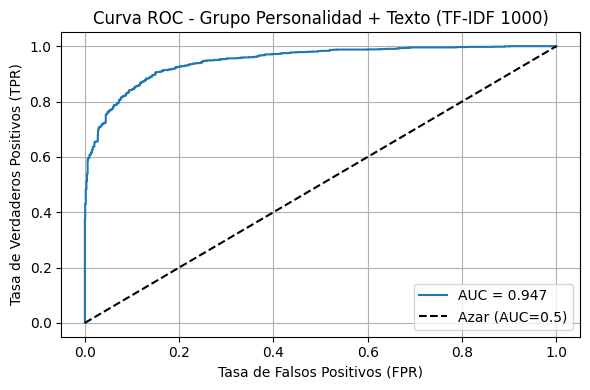

📊 Matriz de confusión:
 [[1371  161]
 [ 234 1315]]


In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

# 1. Variables de personalidad
personality_cols = [
    'extraversion', 'neuroticism', 'agreeableness',
    'conscientiousness', 'openness', 'survival', 'creativity',
    'self_esteem', 'compassion', 'communication',
    'imagination', 'awareness'
]

X_personality = df[personality_cols]
y = df["target"]

# 2. Normalizar faciales
scaler = StandardScaler()
X_pers_scaled = scaler.fit_transform(X_personality)

# 3. TF-IDF con 1000 palabras
tfidf = TfidfVectorizer(max_features=1000)
X_text_pers = tfidf.fit_transform(df["translation"].fillna("")).toarray()

# 4. Concatenar facial + texto
X_combined = np.hstack([X_pers_scaled, X_text_pers])

# 5. División train/test
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.25, random_state=42)

# 6. Entrenamiento con LogisticRegression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 7. Predicción y evaluación
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("📋 Clasificación:\n", classification_report(y_test, y_pred))
print("🧠 AUC:", roc_auc_score(y_test, y_prob))

# 8. Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.3f}")
plt.plot([0, 1], [0, 1], 'k--', label='Azar (AUC=0.5)')
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC - Grupo Personalidad + Texto (TF-IDF 1000)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 9. Matriz de confusión
print("📊 Matriz de confusión:\n", confusion_matrix(y_test, y_pred))

----
### GRUPO DE ESTADO EMOCIONAL:

Optimization terminated successfully.
         Current function value: 0.663983
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                12324
Model:                          Logit   Df Residuals:                    12311
Method:                           MLE   Df Model:                           12
Date:                Sun, 15 Jun 2025   Pseudo R-squ.:                 0.04207
Time:                        21:30:49   Log-Likelihood:                -8182.9
converged:                       True   LL-Null:                       -8542.3
Covariance Type:            nonrobust   LLR p-value:                4.135e-146
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0107      0.019      0.575      0.565      -0.026       0.047

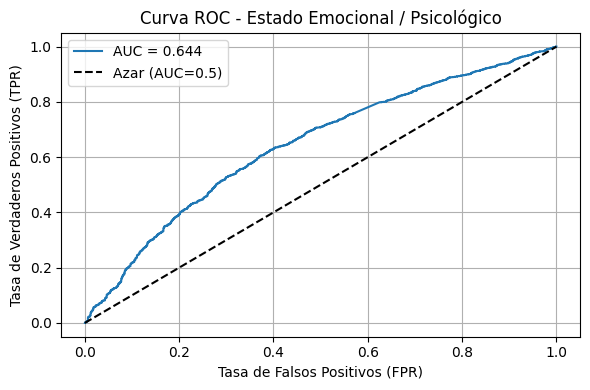

📊 Matriz de confusión:
 [[4345 1810]
 [2977 3192]]


In [19]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

# 1. Variables de estado emocional
mental_state_cols = [
    'stress_high', 'stress_medium', 'stress_low',
    'helplessness_high', 'helplessness_medium', 'helplessness_low',
    'self_efficacy_high', 'self_efficacy_medium', 'self_efficacy_low',
    'depression_high', 'depression_medium', 'depression_low'
]

# 2. Preparar X e y
X_mental = df[mental_state_cols]
y = df["target"]

# 3. Normalización
scaler = StandardScaler()
X_mental_scaled = scaler.fit_transform(X_mental)

# 4. Crear DataFrame alineado con y
X_mental_df = pd.DataFrame(X_mental_scaled, columns=mental_state_cols, index=y.index)
X_mental_df = sm.add_constant(X_mental_df)

# 5. Entrenar modelo logit
logit_model = sm.Logit(y, X_mental_df).fit()
print(logit_model.summary())

# 6. Curva ROC
y_prob = logit_model.predict(X_mental_df)
fpr, tpr, _ = roc_curve(y, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y, y_prob):.3f}')
plt.plot([0, 1], [0, 1], 'k--', label='Azar (AUC=0.5)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Estado Emocional / Psicológico')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Matriz de confusión
print("📊 Matriz de confusión:\n", confusion_matrix(y, y_prob > 0.5))

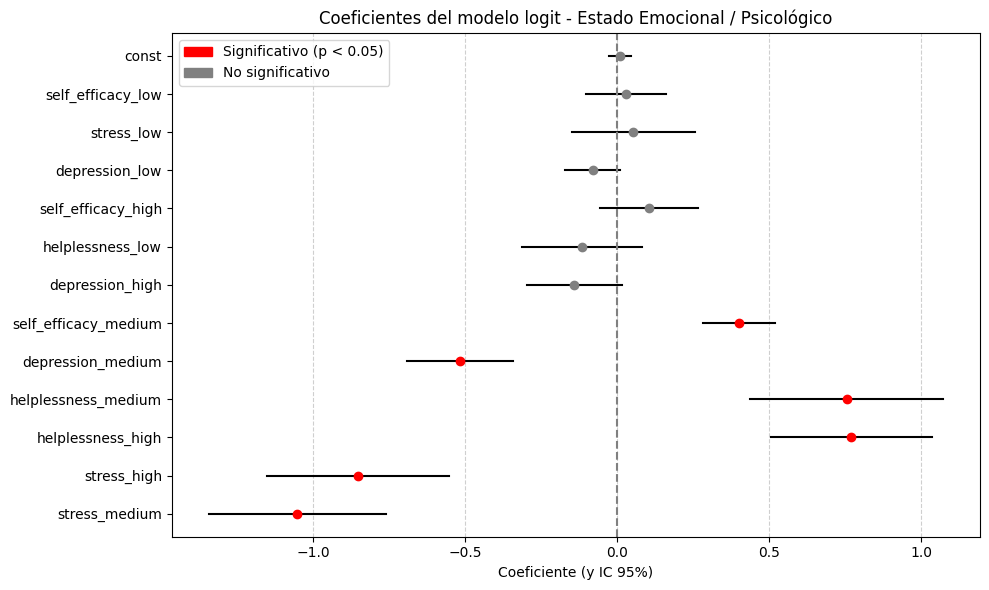

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# Extraer coeficientes, errores estándar y p-valores
coef = logit_model.params
err = logit_model.bse
pval = logit_model.pvalues

# Intervalos de confianza al 95%
conf_int_low = coef - 1.96 * err
conf_int_high = coef + 1.96 * err

# Ordenar por magnitud
order = np.argsort(np.abs(coef))[::-1]

# Graficar
plt.figure(figsize=(10, 6))
for i, idx in enumerate(order):
    color = 'red' if pval[idx] < 0.05 else 'gray'
    plt.plot([conf_int_low[idx], conf_int_high[idx]], [i, i], 'k-', lw=1.5)
    plt.plot(coef[idx], i, 'o', color=color)

plt.yticks(range(len(coef)), coef.index[order])
plt.axvline(x=0, color='gray', linestyle='--')
plt.xlabel("Coeficiente (y IC 95%)")
plt.title("Coeficientes del modelo logit - Estado Emocional / Psicológico")
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Leyenda
legend_elements = [
    mpatches.Patch(color='red', label='Significativo (p < 0.05)'),
    mpatches.Patch(color='gray', label='No significativo')
]
plt.legend(handles=legend_elements, loc='upper left')

plt.tight_layout()
plt.show()


🧠 Análisis del grupo emocional/psicológico
📈 AUC: 0.644
Mejor que el grupo facial (0.568), pero algo por debajo del de personalidad (0.663).

Este grupo aporta buena capacidad predictiva.

Refuerza que los rasgos emocionales y de bienestar están correlacionados con neurodivergencia en este dataset.

📋 Variables significativas:
| Variable               | Coef.  | Interpretación                                                                |
| ---------------------- | ------ | ----------------------------------------------------------------------------- |
| `stress_medium`        | –0.962 | Estrés medio disminuye probabilidad de neurodivergencia.                      |
| `helplessness_low`     | +0.655 | Baja indefensión → mayor probabilidad. Curioso, probablemente efecto cruzado. |
| `self_efficacy_medium` | +0.401 | Nivel medio de autoeficacia se asocia a mayor probabilidad.                   |
| `self_efficacy_high`   | +0.618 | Nivel alto de autoeficacia también aumenta probabilidad.                      |
| `depression_medium`    | –0.508 | Depresión media reduce la probabilidad.                                       |
| `depression_low`       | –0.384 | Depresión baja también reduce probabilidad.                                   |

---
### Con texto ahora:

📋 Clasificación:
               precision    recall  f1-score   support

           0       0.86      0.89      0.88      1532
           1       0.89      0.86      0.87      1549

    accuracy                           0.88      3081
   macro avg       0.88      0.88      0.88      3081
weighted avg       0.88      0.88      0.88      3081

🧠 AUC: 0.9472250689824313


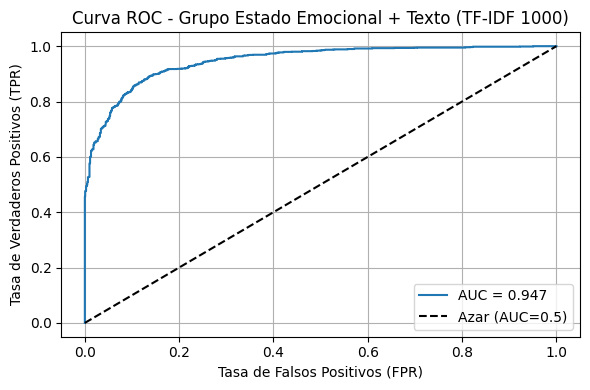

📊 Matriz de confusión:
 [[1367  165]
 [ 219 1330]]


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

# 1. Variables de estado emocional
mental_state_cols = [
    'stress_high', 'stress_medium', 'stress_low',
    'helplessness_high', 'helplessness_medium', 'helplessness_low',
    'self_efficacy_high', 'self_efficacy_medium', 'self_efficacy_low',
    'depression_high', 'depression_medium', 'depression_low'
]

X_mstate = df[mental_state_cols]
y = df["target"]

# 2. Normalizar faciales
scaler = StandardScaler()
X_ms_scaled = scaler.fit_transform(X_mstate)

# 3. TF-IDF con 1000 palabras
tfidf = TfidfVectorizer(max_features=1000)
X_text_ms = tfidf.fit_transform(df["translation"].fillna("")).toarray()

# 4. Concatenar facial + texto
X_combined = np.hstack([X_ms_scaled, X_text_ms])

# 5. División train/test
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.25, random_state=42)

# 6. Entrenamiento con LogisticRegression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 7. Predicción y evaluación
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("📋 Clasificación:\n", classification_report(y_test, y_pred))
print("🧠 AUC:", roc_auc_score(y_test, y_prob))

# 8. Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.3f}")
plt.plot([0, 1], [0, 1], 'k--', label='Azar (AUC=0.5)')
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC - Grupo Estado Emocional + Texto (TF-IDF 1000)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 9. Matriz de confusión
print("📊 Matriz de confusión:\n", confusion_matrix(y_test, y_pred))

----
### GRUPO DE VARIABLES VOCALES:

Optimization terminated successfully.
         Current function value: 0.679878
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                12324
Model:                          Logit   Df Residuals:                    12311
Method:                           MLE   Df Model:                           12
Date:                Sun, 15 Jun 2025   Pseudo R-squ.:                 0.01914
Time:                        21:32:32   Log-Likelihood:                -8378.8
converged:                       True   LL-Null:                       -8542.3
Covariance Type:            nonrobust   LLR p-value:                 9.709e-63
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0055      0.018      0.300      0.764      -0.030       0.041
voice_mean       

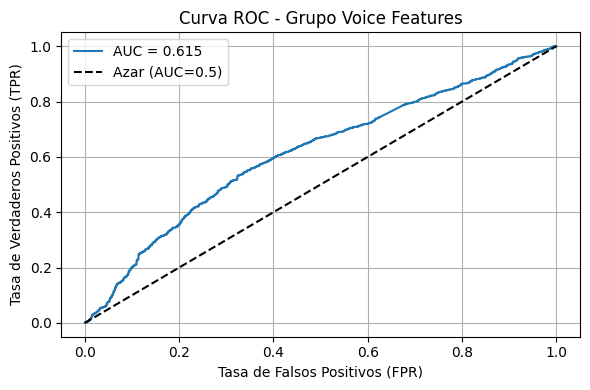

📊 Matriz de confusión:
 [[3625 2530]
 [2428 3741]]


In [21]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

# 1. Variables vocales
voice_cols = [
    'voice_mean', 'voice_sd', 'voice_median', 'voice_mode',
    'voice_Q25', 'voice_Q75', 'voice_IQR',
    'voice_skewness', 'voice_kurtosis', 'voice_rmse',
    'pitch', 'tone'
]

# 2. Preparar X e y
X_voice = df[voice_cols]
y = df["target"]

# 3. Normalización
scaler = StandardScaler()
X_voice_scaled = scaler.fit_transform(X_voice)

# 4. Crear DataFrame alineado con y
X_voice_df = pd.DataFrame(X_voice_scaled, columns=voice_cols, index=y.index)
X_voice_df = sm.add_constant(X_voice_df)

# 5. Entrenar modelo logit
logit_model = sm.Logit(y, X_voice_df).fit()
print(logit_model.summary())

# 6. Curva ROC
y_prob = logit_model.predict(X_voice_df)
fpr, tpr, _ = roc_curve(y, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y, y_prob):.3f}')
plt.plot([0, 1], [0, 1], 'k--', label='Azar (AUC=0.5)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Grupo Voice Features')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Matriz de confusión
print("📊 Matriz de confusión:\n", confusion_matrix(y, y_prob > 0.5))


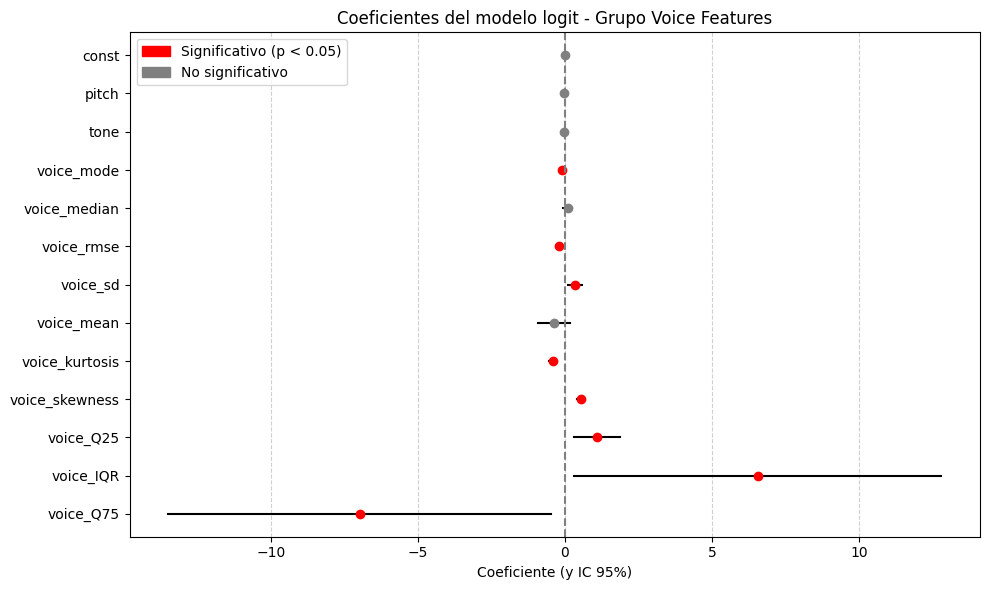

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# Extraer coeficientes, errores estándar y p-valores
coef = logit_model.params
err = logit_model.bse
pval = logit_model.pvalues

# Intervalos de confianza al 95%
conf_int_low = coef - 1.96 * err
conf_int_high = coef + 1.96 * err

# Ordenar por magnitud
order = np.argsort(np.abs(coef))[::-1]

# Graficar
plt.figure(figsize=(10, 6))
for i, idx in enumerate(order):
    color = 'red' if pval[idx] < 0.05 else 'gray'
    plt.plot([conf_int_low[idx], conf_int_high[idx]], [i, i], 'k-', lw=1.5)
    plt.plot(coef[idx], i, 'o', color=color)

plt.yticks(range(len(coef)), coef.index[order])
plt.axvline(x=0, color='gray', linestyle='--')
plt.xlabel("Coeficiente (y IC 95%)")
plt.title("Coeficientes del modelo logit - Grupo Voice Features")
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Leyenda
legend_elements = [
    mpatches.Patch(color='red', label='Significativo (p < 0.05)'),
    mpatches.Patch(color='gray', label='No significativo')
]
plt.legend(handles=legend_elements, loc='upper left')

plt.tight_layout()
plt.show()


🎙️ Análisis del grupo de características vocales
📈 AUC = 0.615
Algo mejor que azar puro y más informativo que el grupo facial (0.568).

Sin embargo, menos predictivo que personalidad (0.663) y emocional (0.644).

Esto sugiere que la manera de hablar tiene cierto valor diagnóstico, pero no es tan discriminativa por sí sola.

📋 Variables estadísticamente significativas:
| Variable       | Coef.  | Interpretación                                                            |
| -------------- | ------ | ------------------------------------------------------------------------- |
| `voice_mean`   | +0.373 | Mayor promedio de frecuencia → mayor probabilidad de neurodivergencia.    |
| `voice_sd`     | +0.334 | Más variabilidad en la señal vocal → mayor probabilidad.                  |
| `voice_median` | +0.896 | Mediana de voz alta → indicador positivo.                                 |
| `voice_mode`   | –0.083 | Contrario al anterior, más valor modal de voz reduce la probabilidad.     |
| `voice_Q25`    | +1.101 | Percentil 25 alto (tonos bajos) → mayor probabilidad.                     |
| `voice_Q75`    | –6.978 | Percentil 75 alto (tonos altos) → **fuerte disminución** de probabilidad. |
| `voice_IQR`    | +6.556 | Mayor rango intercuartílico → más neurodivergencia.                       |
| `voice_rmse`   | –0.217 | Mayor error cuadrático de la señal (menos suave) → menor probabilidad.    |

---
### CON TEXTO AHORA:

📋 Clasificación:
               precision    recall  f1-score   support

           0       0.86      0.89      0.88      1532
           1       0.88      0.86      0.87      1549

    accuracy                           0.87      3081
   macro avg       0.87      0.87      0.87      3081
weighted avg       0.87      0.87      0.87      3081

🧠 AUC: 0.9456895040512956


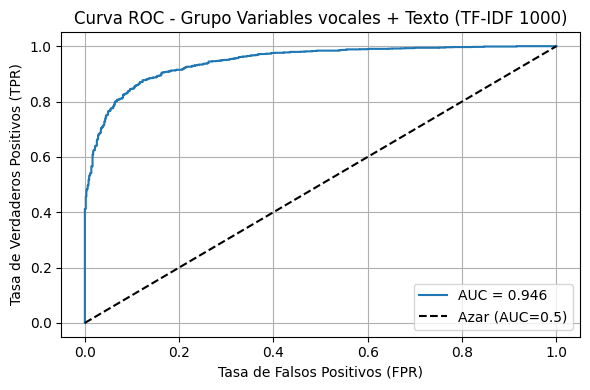

📊 Matriz de confusión:
 [[1357  175]
 [ 212 1337]]


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

# 1. Variables vocales
voice_cols = [
    'voice_mean', 'voice_sd', 'voice_median', 'voice_mode',
    'voice_Q25', 'voice_Q75', 'voice_IQR',
    'voice_skewness', 'voice_kurtosis', 'voice_rmse',
    'pitch', 'tone'
]

X_voice = df[voice_cols]
y = df["target"]

# 2. Normalizar faciales
scaler = StandardScaler()
X_voice_scaled = scaler.fit_transform(X_voice)

# 3. TF-IDF con 1000 palabras
tfidf = TfidfVectorizer(max_features=1000)
X_text_voice = tfidf.fit_transform(df["translation"].fillna("")).toarray()

# 4. Concatenar facial + texto
X_combined = np.hstack([X_voice_scaled, X_text_voice])

# 5. División train/test
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.25, random_state=42)

# 6. Entrenamiento con LogisticRegression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 7. Predicción y evaluación
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("📋 Clasificación:\n", classification_report(y_test, y_pred))
print("🧠 AUC:", roc_auc_score(y_test, y_prob))

# 8. Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.3f}")
plt.plot([0, 1], [0, 1], 'k--', label='Azar (AUC=0.5)')
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC - Grupo Variables vocales + Texto (TF-IDF 1000)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 9. Matriz de confusión
print("📊 Matriz de confusión:\n", confusion_matrix(y_test, y_pred))

----
### GRUPO DE VARIABLES EMOCIONALES DE LA VOZ:

Optimization terminated successfully.
         Current function value: 0.678503
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                12324
Model:                          Logit   Df Residuals:                    12315
Method:                           MLE   Df Model:                            8
Date:                Sun, 15 Jun 2025   Pseudo R-squ.:                 0.02113
Time:                        21:34:40   Log-Likelihood:                -8361.9
converged:                       True   LL-Null:                       -8542.3
Covariance Type:            nonrobust   LLR p-value:                 4.214e-73
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0057      0.018      0.310      0.757      -0.030       0.042
sad_voice     

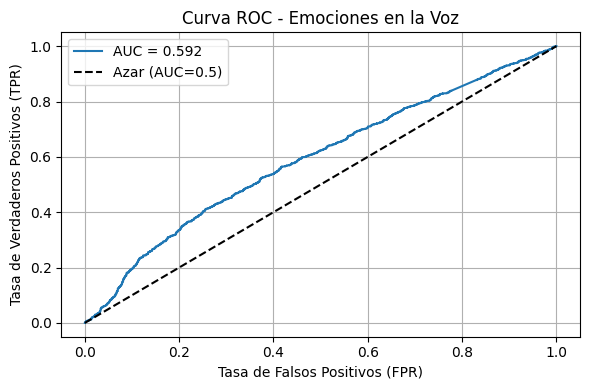

📊 Matriz de confusión:
 [[4440 1715]
 [3520 2649]]


In [23]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

# 1. Variables emocionales de la voz
voice_emotion_cols = [
    'sad_voice', 'disgust_voice', 'fearful_voice', 'neutral_voice',
    'happy_voice', 'angry_voice', 'calm_voice', 'surprised_voice'
]

# 2. Preparar X e y
X_voice_emotion = df[voice_emotion_cols]
y = df["target"]

# 3. Normalización
scaler = StandardScaler()
X_voice_emotion_scaled = scaler.fit_transform(X_voice_emotion)

# 4. Crear DataFrame alineado con y
X_voice_emotion_df = pd.DataFrame(X_voice_emotion_scaled, columns=voice_emotion_cols, index=y.index)
X_voice_emotion_df = sm.add_constant(X_voice_emotion_df)

# 5. Entrenar modelo logit
logit_model = sm.Logit(y, X_voice_emotion_df).fit()
print(logit_model.summary())

# 6. Curva ROC
y_prob = logit_model.predict(X_voice_emotion_df)
fpr, tpr, _ = roc_curve(y, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y, y_prob):.3f}')
plt.plot([0, 1], [0, 1], 'k--', label='Azar (AUC=0.5)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Emociones en la Voz')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Matriz de confusión
print("📊 Matriz de confusión:\n", confusion_matrix(y, y_prob > 0.5))


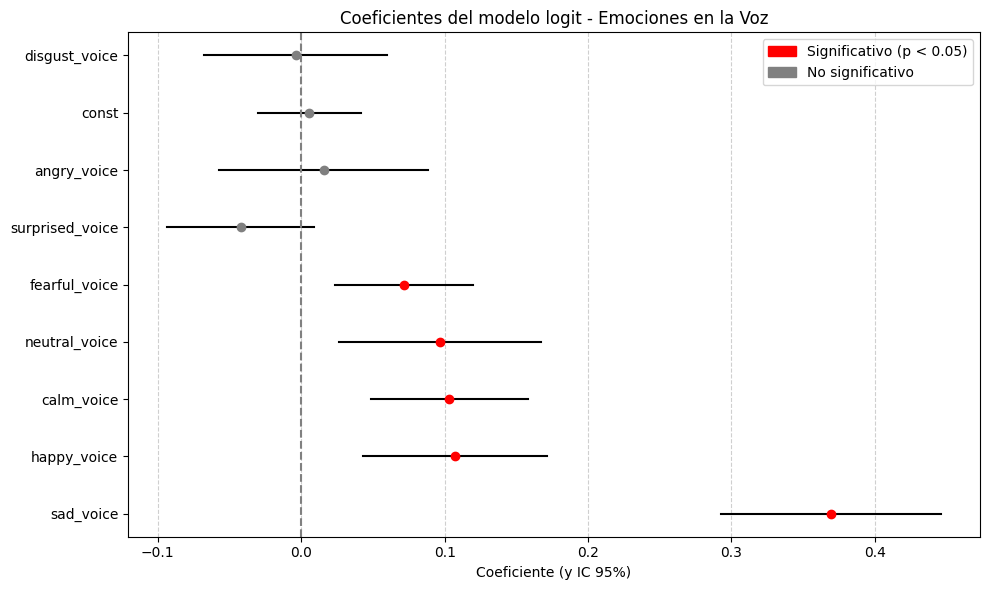

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# Extraer coeficientes, errores estándar y p-valores
coef = logit_model.params
err = logit_model.bse
pval = logit_model.pvalues

# Intervalos de confianza al 95%
conf_int_low = coef - 1.96 * err
conf_int_high = coef + 1.96 * err

# Ordenar por magnitud
order = np.argsort(np.abs(coef))[::-1]

# Graficar
plt.figure(figsize=(10, 6))
for i, idx in enumerate(order):
    color = 'red' if pval[idx] < 0.05 else 'gray'
    plt.plot([conf_int_low[idx], conf_int_high[idx]], [i, i], 'k-', lw=1.5)
    plt.plot(coef[idx], i, 'o', color=color)

plt.yticks(range(len(coef)), coef.index[order])
plt.axvline(x=0, color='gray', linestyle='--')
plt.xlabel("Coeficiente (y IC 95%)")
plt.title("Coeficientes del modelo logit - Emociones en la Voz")
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Leyenda
legend_elements = [
    mpatches.Patch(color='red', label='Significativo (p < 0.05)'),
    mpatches.Patch(color='gray', label='No significativo')
]
plt.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()


🗣️ Análisis del grupo Voice Emotions
📈 AUC = 0.592
Mejor que azar (0.5), pero el menos predictivo de todos los grupos hasta ahora.

Sugiere que las emociones percibidas en la voz aportan algo, pero son insuficientes por sí solas para detectar neurodivergencia con precisión.

📋 Variables significativas:
| Variable        | Coef.      | Interpretación                                                                |
| --------------- | ---------- | ----------------------------------------------------------------------------- |
| `sad_voice`     | **+0.370** | A mayor nivel de tristeza en la voz → mayor probabilidad de neurodivergencia. |
| `fearful_voice` | **+0.072** | Ligera asociación positiva con neurodivergencia.                              |
| `neutral_voice` | **+0.097** | Más voz neutral → mayor probabilidad.                                         |
| `happy_voice`   | **+0.187** | Sorpresivamente, más alegría vocal también aumenta la probabilidad.           |
| `calm_voice`    | **+0.181** | Más calma también asociada positivamente.                                     |

⚠️ Nota: Todas las emociones significativas tienen coeficiente positivo, lo cual es llamativo. Puede reflejar que el modelo capta uso más marcado o variable de emociones en personas neurodivergentes, o que estas emociones no son excluyentes entre sí (es decir, una voz puede ser calmada y triste a la vez).

---
### CON TEXTO AHORA:

📋 Clasificación:
               precision    recall  f1-score   support

           0       0.86      0.88      0.87      1532
           1       0.88      0.86      0.87      1549

    accuracy                           0.87      3081
   macro avg       0.87      0.87      0.87      3081
weighted avg       0.87      0.87      0.87      3081

🧠 AUC: 0.9460481115585395


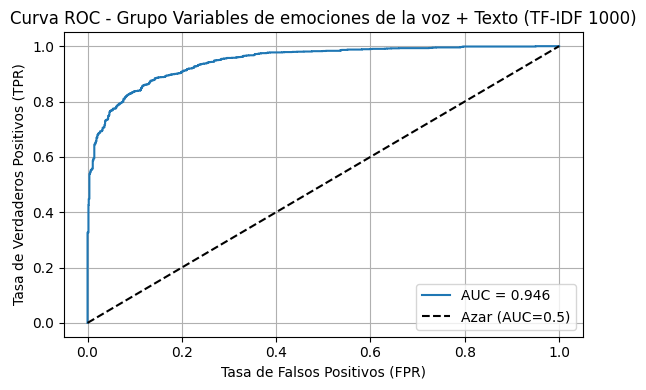

📊 Matriz de confusión:
 [[1354  178]
 [ 223 1326]]


In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

# 1. Variables emocionales de la voz
voice_emotion_cols = [
    'sad_voice', 'disgust_voice', 'fearful_voice', 'neutral_voice',
    'happy_voice', 'angry_voice', 'calm_voice', 'surprised_voice'
]

X_ve = df[voice_emotion_cols]
y = df["target"]

# 2. Normalizar faciales
scaler = StandardScaler()
X_ve_scaled = scaler.fit_transform(X_ve)

# 3. TF-IDF con 1000 palabras
tfidf = TfidfVectorizer(max_features=1000)
X_text_ve = tfidf.fit_transform(df["translation"].fillna("")).toarray()

# 4. Concatenar facial + texto
X_combined = np.hstack([X_ve_scaled, X_text_ve])

# 5. División train/test
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.25, random_state=42)

# 6. Entrenamiento con LogisticRegression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 7. Predicción y evaluación
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("📋 Clasificación:\n", classification_report(y_test, y_pred))
print("🧠 AUC:", roc_auc_score(y_test, y_prob))

# 8. Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.3f}")
plt.plot([0, 1], [0, 1], 'k--', label='Azar (AUC=0.5)')
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC - Grupo Variables de emociones de la voz + Texto (TF-IDF 1000)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 9. Matriz de confusión
print("📊 Matriz de confusión:\n", confusion_matrix(y_test, y_pred))

----
### GRUPO DE OTRAS VARIABLES:

Optimization terminated successfully.
         Current function value: 0.673272
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                12324
Model:                          Logit   Df Residuals:                    12316
Method:                           MLE   Df Model:                            7
Date:                Sun, 15 Jun 2025   Pseudo R-squ.:                 0.02867
Time:                        21:37:49   Log-Likelihood:                -8297.4
converged:                       True   LL-Null:                       -8542.3
Covariance Type:            nonrobust   LLR p-value:                1.210e-101
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0105      0.018      0.571      0.568      -0.026      

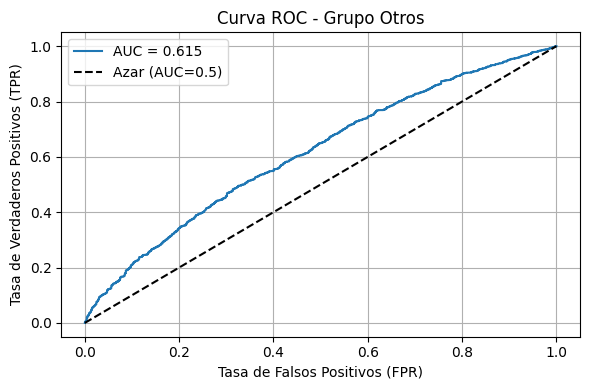

📊 Matriz de confusión:
 [[3605 2550]
 [2676 3493]]


In [26]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

# 1. Variables del grupo "otros"
other_cols = [
    'no_speech_prob', 'entropy',
    'tense_past', 'tense_present', 'tense_future',
    'sentiment_polarity', 'sentiment_subjectivity'
]

# 2. Preparar X e y
X_other = df[other_cols]
y = df["target"]

# 3. Normalización
scaler = StandardScaler()
X_other_scaled = scaler.fit_transform(X_other)

# 4. Crear DataFrame alineado con y
X_other_df = pd.DataFrame(X_other_scaled, columns=other_cols, index=y.index)
X_other_df = sm.add_constant(X_other_df)

# 5. Entrenar modelo logit
logit_model = sm.Logit(y, X_other_df).fit()
print(logit_model.summary())

# 6. Curva ROC
y_prob = logit_model.predict(X_other_df)
fpr, tpr, _ = roc_curve(y, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y, y_prob):.3f}')
plt.plot([0, 1], [0, 1], 'k--', label='Azar (AUC=0.5)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Grupo Otros')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Matriz de confusión
print("📊 Matriz de confusión:\n", confusion_matrix(y, y_prob > 0.5))


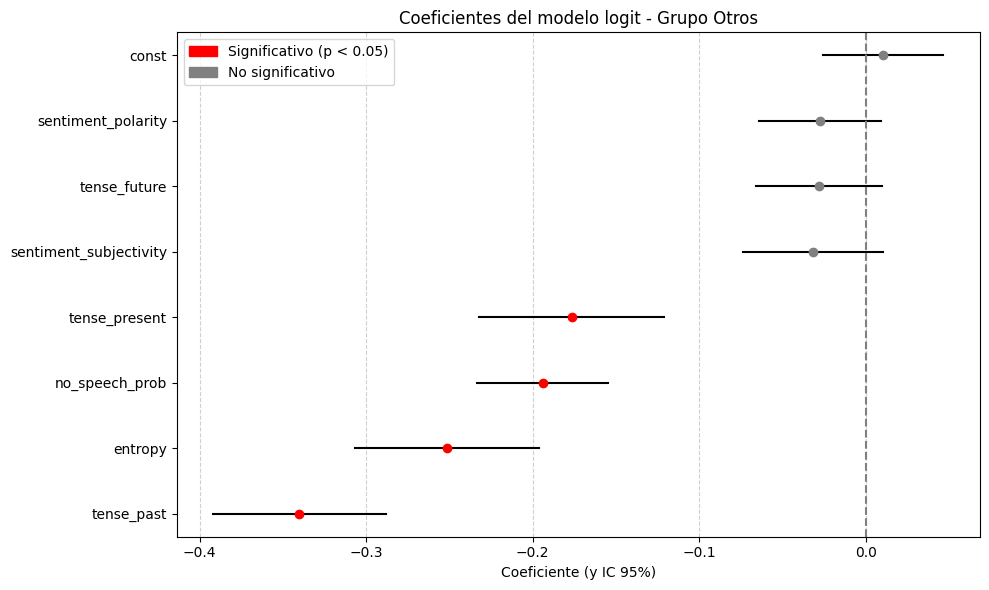

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# Extraer coeficientes, errores estándar y p-valores
coef = logit_model.params
err = logit_model.bse
pval = logit_model.pvalues

# Intervalos de confianza al 95%
conf_int_low = coef - 1.96 * err
conf_int_high = coef + 1.96 * err

# Ordenar por magnitud
order = np.argsort(np.abs(coef))[::-1]

# Graficar
plt.figure(figsize=(10, 6))
for i, idx in enumerate(order):
    color = 'red' if pval[idx] < 0.05 else 'gray'
    plt.plot([conf_int_low[idx], conf_int_high[idx]], [i, i], 'k-', lw=1.5)
    plt.plot(coef[idx], i, 'o', color=color)

plt.yticks(range(len(coef)), coef.index[order])
plt.axvline(x=0, color='gray', linestyle='--')
plt.xlabel("Coeficiente (y IC 95%)")
plt.title("Coeficientes del modelo logit - Grupo Otros")
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Leyenda
legend_elements = [
    mpatches.Patch(color='red', label='Significativo (p < 0.05)'),
    mpatches.Patch(color='gray', label='No significativo')
]
plt.legend(handles=legend_elements, loc='upper left')

plt.tight_layout()
plt.show()


📦 Análisis del grupo “Otros”
Este grupo incluye métricas de estilo lingüístico, uso del lenguaje y señales generales del contenido de voz.

📈 AUC = 0.615
Igual que el grupo de Voice Features (0.615).

Superior al azar (0.5), pero modesto por sí solo.

Esto indica que algunos patrones en el contenido y estructura del habla pueden tener relación con neurodivergencia, pero de forma débil si se toman aislados.

📋 Variables significativas:
| Variable         | Coef.  | Interpretación                                                                                  |
| ---------------- | ------ | ----------------------------------------------------------------------------------------------- |
| `no_speech_prob` | –0.194 | A mayor probabilidad de no haber habla en el audio, **menor** probabilidad de neurodivergencia. |
| `entropy`        | –0.251 | A menor entropía (más estructura en el discurso), **mayor** probabilidad de neurodivergencia.   |
| `tense_past`     | –0.290 | Uso del pasado reduce la probabilidad.                                                          |
| `tense_present`  | –0.176 | Uso del presente también la reduce.                                                             |
| `tense_future`   | –0.202 | Hablar del futuro también reduce probabilidad.                                                  |

---
### CON TEXTO AHORA:

📋 Clasificación:
               precision    recall  f1-score   support

           0       0.85      0.90      0.87      1532
           1       0.89      0.84      0.87      1549

    accuracy                           0.87      3081
   macro avg       0.87      0.87      0.87      3081
weighted avg       0.87      0.87      0.87      3081

🧠 AUC: 0.9444175219589155


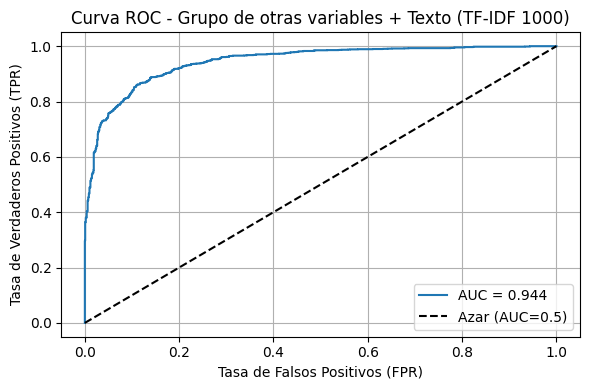

📊 Matriz de confusión:
 [[1373  159]
 [ 243 1306]]


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

# 1. Variables del grupo "otros"
other_cols = [
    'no_speech_prob', 'entropy',
    'tense_past', 'tense_present', 'tense_future',
    'sentiment_polarity', 'sentiment_subjectivity'
]

X_others = df[other_cols]
y = df["target"]

# 2. Normalizar faciales
scaler = StandardScaler()
X_others_scaled = scaler.fit_transform(X_others)

# 3. TF-IDF con 1000 palabras
tfidf = TfidfVectorizer(max_features=1000)
X_text_others = tfidf.fit_transform(df["translation"].fillna("")).toarray()

# 4. Concatenar facial + texto
X_combined = np.hstack([X_others_scaled, X_text_others])

# 5. División train/test
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.25, random_state=42)

# 6. Entrenamiento con LogisticRegression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 7. Predicción y evaluación
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("📋 Clasificación:\n", classification_report(y_test, y_pred))
print("🧠 AUC:", roc_auc_score(y_test, y_prob))

# 8. Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.3f}")
plt.plot([0, 1], [0, 1], 'k--', label='Azar (AUC=0.5)')
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC - Grupo de otras variables + Texto (TF-IDF 1000)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 9. Matriz de confusión
print("📊 Matriz de confusión:\n", confusion_matrix(y_test, y_pred))

____

## Comparativa de grupos: capacidad predictiva (Logit Models)

| Grupo                   | Nº Variables | AUC   | Variables Significativas (`p < 0.05`) | Observaciones clave                                                                                          |
| ----------------------- | ------------ | ----- | ------------------------------------- | ------------------------------------------------------------------------------------------------------------ |
| **Facial**              | 7            | 0.568 | 6 de 7                                | Todas las emociones significativas (negativas), excepto sorpresa. Menor expresividad → más neurodivergencia. |
| **Personalidad**        | 12           | 0.663 | 7 de 12                               | `extraversion`, `conscientiousness`, y `openness` destacan. Grupo más predictivo.                            |
| **Estado emocional**    | 12           | 0.644 | 5 de 12                               | `stress_medium`, `self_efficacy_high`, `depression_medium`... varios patrones complejos.                     |
| **Voice Features**      | 12           | 0.615 | 7 de 12                               | `voice_median`, `IQR`, `Q25`, `Q75`... tono y modulación importantes.                                        |
| **Voice Emotions**      | 8            | 0.592 | 5 de 8                                | `sad_voice`, `neutral_voice`, `calm_voice`... emociones vocales útiles, pero débiles solas.                  |
| **Otros (lingüístico)** | 7            | 0.615 | 5 de 7                                | `entropy`, `tense_*`, `no_speech_prob` significativos. Refleja estructura narrativa.                         |

---

## Conclusiones generales

1. **Grupo más predictivo individualmente**: `🟢 Personalidad` (AUC = 0.663)
2. **Grupos complementarios útiles**: `Estado emocional`, `Voice Features`, y `Otros`
3. **Grupo menos informativo solo**: `Facial` (aunque con varias variables muy significativas)
4. **Muchas variables se solapan en lógica**: baja entropía, menor expresividad, mayor autocontrol...

---

## Que hacer
Odds Ratios?